# BangleBeat

The following notebook walks through the process of making a machine learning model to improve BangleJS2 heart rate accuracy based on prior data. The ML model runs directly on the BangleJS2 watch and should serve as an easy to use pipeline for folks to make thier own Bangle more accurate for them. Further work may attempt to generalize this approach to yield an open source watch which actively learns how to improve its own heart rate measurements. 



## Data Capture

First, we should assess how good or bad the BangleJS2 performs when compared to other wearable devices. This includes the following devices:

- BangleJS2 Smart Watch
- Garmin Instinct 2X Smart Watch
- Polar H10 ECG Chest Strap

These are all supported to a sufficient degree by [Gadgetbridge](https://gadgetbridge.org/). However, in the initial phases of this project I found that the BangleJS2 does not sample heart rate data nearly as fast as the Garmin does. To give this model a fighting chance I wrote [loglog](https://github.com/lucspec/BangleApps/tree/master/apps/loglog) -- a BangleJS2 app to prioritize data collection over battery life. Initial testing yields a high enough data density to be more comprable with the other two sensors in this work.

## Analysis

With our sensors and collection mechanisms in place, we can start looking at some data.

In [129]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import glob
import os

# ML Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Plotting Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

print("Environment Ready")

Environment Ready


With some boilerplate out of the way, let's load up our data and see what we have.

Begin by querying the SQLite db to see what the tables look like. I arrived at the entries in the `hr_tables` list by opening up `sqlitebrowser` (included in the nix flake) to see which data tables might have what I want.

Bangle JS2: 1 candidate table
Garmin: 15 tables, 3 which mention events / heart rate specifically
Polar: 1 candidate table

In [130]:
import sqlite3

conn = sqlite3.connect('./data/Gadgetbridge.db')

# Tables that likely have HR data
hr_tables = [
    'BANGLE_JSACTIVITY_SAMPLE',
    'GARMIN_ACTIVITY_SAMPLE',
    #'GARMIN_EVENT_SAMPLE', # commented as it doesn't contain HR data
    'GARMIN_HEART_RATE_RESTING_SAMPLE',
    'GARMIN_FIT_FILE',
    'POLAR_H10_ACTIVITY_SAMPLE'
]
for table in hr_tables:
    print("\n" + "="*80)
    print(f"TABLE: {table}")
    print("="*80)
    
    cursor = conn.cursor()
    
    # Get schema
    cursor.execute(f"PRAGMA table_info({table});")
    columns = cursor.fetchall()
    col_names = [col[1] for col in columns]
    
    print("\nColumns:")
    for col in columns:
        col_id, col_name, col_type, not_null, default, pk = col
        print(f"  {col_name:30s} {col_type:15s}")
    
    # Get count
    cursor.execute(f"SELECT COUNT(*) FROM {table};")
    count = cursor.fetchone()[0]
    
    # Show sample rows with headers
    if count > 0:
        cursor.execute(f"SELECT * FROM {table} LIMIT 3;")
        samples = cursor.fetchall()
        
        print("\nSample rows (of {count:,} total rows)\n")
        print("  " + " | ".join(f"{col:14s}" for col in col_names))
        print("  " + "-" * (len(col_names) * 16))
        for row in samples:
            print("  " + " | ".join(f"{str(val):14s}" for val in row))

conn.close()


TABLE: BANGLE_JSACTIVITY_SAMPLE

Columns:
  TIMESTAMP                      INTEGER        
  DEVICE_ID                      INTEGER        
  USER_ID                        INTEGER        
  RAW_INTENSITY                  INTEGER        
  STEPS                          INTEGER        
  RAW_KIND                       INTEGER        
  HEART_RATE                     INTEGER        

Sample rows (of {count:,} total rows)

  TIMESTAMP      | DEVICE_ID      | USER_ID        | RAW_INTENSITY  | STEPS          | RAW_KIND       | HEART_RATE    
  ----------------------------------------------------------------------------------------------------------------
  1763191201     | 5              | 1              | 216            | 0              | 8              | 76            
  1763238600     | 5              | 1              | 288            | 0              | 0              | 78            
  1763239200     | 5              | 1              | 256            | 0              | 0              

In [131]:
# =============================================================================
# CONFIGURATION
# =============================================================================
DB_SEARCH_PATHS = [ 
    "./data/Gadgetbridge*.db",
    "./data/Gadgetbridge*/database/Gadgetbridge",
]
CSV_SEARCH_PATHS = [
    #"./data/loglog*.csv",
    "./data/HeartRateRecord*.csv",
]

# =============================================================================
# FUNCTION: LOAD DATABASE DATA
# =============================================================================
def load_db_data(db_pattern):
    dataframes = []
    dbs = glob.glob(db_pattern)
    
    # Mapping table names to timestamp units based on Gadgetbridge schema
    # Most ACTIVITY tables are seconds, EVENT/SAMPLE tables often ms
    table_configs = {
        'GARMIN_ACTIVITY_SAMPLE': {'unit': 's'},
        'BANGLE_JSACTIVITY_SAMPLE': {'unit': 's'},
        'POLAR_H10_ACTIVITY_SAMPLE': {'unit': 's'},
        # Add others if needed
    }

    type_to_table = {
        'GARMIN_INSTINCT_2X_SOLAR': 'GARMIN_ACTIVITY_SAMPLE',
        'BANGLEJS': 'BANGLE_JSACTIVITY_SAMPLE',
        'POLAR': 'POLAR_H10_ACTIVITY_SAMPLE',
    }

    for db_path in dbs:
        try:
            conn = sqlite3.connect(db_path)
            
            # Get Devices
            devices = pd.read_sql_query("SELECT * FROM DEVICE", conn)
            
            for _, device in devices.iterrows():
                # Resolve table name
                d_type = device.get('TYPE_NAME', '')
                if not d_type: continue
                
                table = None
                if d_type in type_to_table:
                    table = type_to_table[d_type]
                elif 'GARMIN' in d_type:
                    table = 'GARMIN_ACTIVITY_SAMPLE'
                elif 'BANGLE' in d_type:
                    table = 'BANGLE_JSACTIVITY_SAMPLE'
                elif 'POLAR' in d_type:
                    table = 'POLAR_H10_ACTIVITY_SAMPLE'
                
                if not table: continue
                
                # Check if table exists
                check = conn.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table}'").fetchone()
                if not check: continue

                # Query Data
                query = f"SELECT TIMESTAMP, HEART_RATE FROM {table} WHERE DEVICE_ID = ? AND HEART_RATE > 0"
                df = pd.read_sql_query(query, conn, params=(device['_id'],))
                
                if not df.empty:
                    # Apply correct timestamp conversion
                    ts_unit = table_configs.get(table, {}).get('unit', 's')
                    df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit=ts_unit)
                    df['device_name'] = device['NAME']
                    df['device_type'] = d_type
                    df['source'] = 'DATABASE'
                    dataframes.append(df)
            
            conn.close()
        except Exception as e:
            print(f"Error reading {db_path}: {e}")

    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# =============================================================================
# FUNCTION: LOAD LOGLOG CSV DATA (HAS ACCELEROMETER)
# =============================================================================
def load_csv_data(csv_pattern):
    csvs = glob.glob(csv_pattern)
    dataframes = []
    
    for f in csvs:
        try:
            # Latin-1 often helps with the 'µ' symbol in units
            df = pd.read_csv(f, encoding='latin-1') 
            df.columns = df.columns.str.strip()
            
            # Rename for consistency
            rename_map = {
                'Epoch (ms)': 'EPOCH_MS',
                'BPM': 'HEART_RATE',
                'X': 'x', 'Y': 'y', 'Z': 'z', 'Total': 'total_accel'
            }
            df = df.rename(columns=rename_map)
            
            # Filter valid HR
            df = df[ (df['HEART_RATE'].notna()) & (df['HEART_RATE'] > 0) ]
            
            # Convert Timestamps (Loglog uses MS)
            df['datetime'] = pd.to_datetime(df['EPOCH_MS'], unit='ms')
            df['device_name'] = 'BangleJS-CSV'
            df['device_type'] = 'BANGLEJS_CSV'
            df['source'] = 'CSV'
            
            # Ensure accel columns exist
            for col in ['x', 'y', 'z']:
                if col not in df.columns:
                    df[col] = np.nan
            
            dataframes.append(df)
        except Exception as e:
            print(f"Skipping {f}: {e}")
            
    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# =============================================================================
# EXECUTE LOAD
# =============================================================================
dbs = []

for gadgetbridge_file in DB_SEARCH_PATHS:
    df_db = load_db_data(gadgetbridge_file)
    print(f"Loaded {len(df_db):.3g} rows from {len(glob.glob(gadgetbridge_file)):3.0f} files matching \'{gadgetbridge_file}\'")
    dbs.append(df_db)

for csv_file in CSV_SEARCH_PATHS:
    df_csv = load_csv_data(csv_file)
    print(f"Loaded {len(df_csv):.3g} rows from {len(glob.glob(csv_file)):3.0f} files matching \'{csv_file}\'")
    dbs.append(df_csv)

# Combine
hr_data = pd.concat(dbs, ignore_index=True).sort_values('datetime')
print()
print(f"  Total Combined Data: {len(hr_data):.3g} rows.")

## NOTE -- THIS MODIFIES hr_data INPLACE, REDUCING THE SIZE OF THE DATA SET
hr_data.drop_duplicates(subset=None, inplace=True)
print(f"After Drop Duplicates: {len(hr_data):.3g} rows.")


Loaded 1.65e+06 rows from   9 files matching './data/Gadgetbridge*.db'
Loaded 3.99e+05 rows from   2 files matching './data/Gadgetbridge*/database/Gadgetbridge'
Loaded 7.5e+04 rows from   2 files matching './data/HeartRateRecord*.csv'

  Total Combined Data: 2.12e+06 rows.
After Drop Duplicates: 3.54e+05 rows.


In [132]:
print("\nDevices in combined data:")
devs = hr_data['device_name'].unique()
print(devs)
for device in hr_data['device_name'].unique():
    device_data = hr_data[hr_data['device_name'] == device]
    count = len(device_data)
    device_type = device_data['device_type'].iloc[0]
    date_range = device_data['datetime']
    hr_range = device_data['HEART_RATE']
    
    print(f"\n  {device} ({device_type}):")
    print(f"    Measurements: {count:,}")
    print(f"    Date range: {date_range.min().strftime('%Y-%m-%d %H:%M')} to {date_range.max().strftime('%Y-%m-%d %H:%M')}")
    print(f"    HR range: {hr_range.min():.0f} - {hr_range.max():.0f} bpm (mean: {hr_range.mean():.1f})")
    
    ## Show accelerometer data if available
    #if 'x' in device_data.columns:
    #    accel_complete = device_data[['x', 'y', 'z']].notna().all(axis=1).sum()
    #    if accel_complete > 0:
    #        print(f"    Accelerometer: {accel_complete:,} samples")


Devices in combined data:
['Bangle.js db9a' 'BangleJS-CSV' 'Instinct 2X Solar' 'Polar H10 CC3A8829']

  Bangle.js db9a (BANGLEJS):
    Measurements: 24,284
    Date range: 1970-01-01 00:00 to 2025-11-24 11:10
    HR range: 49 - 184 bpm (mean: 80.4)

  BangleJS-CSV (BANGLEJS_CSV):
    Measurements: 75,046
    Date range: 1970-01-21 09:47 to 1970-01-21 10:01
    HR range: 53 - 115 bpm (mean: 79.2)

  Instinct 2X Solar (GARMIN_INSTINCT_2X_SOLAR):
    Measurements: 164,954
    Date range: 2025-06-08 14:12 to 2025-11-25 18:59
    HR range: 38 - 176 bpm (mean: 76.2)

  Polar H10 CC3A8829 (POLARH10):
    Measurements: 89,451
    Date range: 2025-11-09 18:26 to 2025-11-25 02:19
    HR range: 58 - 174 bpm (mean: 83.2)


In [133]:
# =============================================================================
# STEP 2: ALIGNMENT & PREPARATION
# =============================================================================
ALIGNMENT_TOLERANCE = '2s'
TRAINING_FEATURES = ['HEART_RATE', 'x', 'y', 'z']

# -------------------------------------------------------------------
# 0. REMOVE BAD TIMESTAMPS (epoch 0, null, corrupted)
# -------------------------------------------------------------------
#MIN_REAL_TIMESTAMP = pd.Timestamp("2000-01-01")
MIN_REAL_TIMESTAMP = pd.Timestamp("2025-10-01")

hr_data = hr_data.dropna(subset=["datetime"])
hr_data = hr_data[hr_data["datetime"] >= MIN_REAL_TIMESTAMP]


# 1. Split reference (GARMIN + POLAR) and bangle
reference_df = hr_data[
    hr_data['device_type'].str.contains('GARMIN|POLAR', case=False, na=False)
].copy()
reference_df = reference_df.sort_values('datetime').dropna(subset=['HEART_RATE'])

bangle_df = hr_data[
    hr_data['device_type'].str.contains('BANGLE', case=False, na=False)
].copy()
bangle_df = bangle_df.sort_values('datetime')

print(f"Reference Samples: {len(reference_df):,}")
print(f"   Bangle Samples: {len(bangle_df):,}")


# 2. Detect and remove large gaps in reference data
MAX_GAP = pd.Timedelta("5s")

reference_df["delta"] = reference_df["datetime"].diff()
reference_df["segment"] = (reference_df["delta"] > MAX_GAP).cumsum()
reference_df = reference_df.drop(columns=["delta"])

valid_segments = []
for seg_id, seg_df in reference_df.groupby("segment"):
    if len(seg_df) < 10:
        continue
    valid_segments.append(seg_df)

reference_df = pd.concat(valid_segments, ignore_index=True).sort_values("datetime")
print(f"Reference segments after gap-removal: {reference_df['segment'].nunique()}")


# 3. Merge-asof only within valid segments
aligned_blocks = []

for seg_id, seg_ref in reference_df.groupby("segment"):
    seg_start = seg_ref["datetime"].min()
    seg_end   = seg_ref["datetime"].max()

    seg_bangle = bangle_df[
        (bangle_df["datetime"] >= seg_start) &
        (bangle_df["datetime"] <= seg_end)
    ]
    if seg_bangle.empty:
        continue

    merged = pd.merge_asof(
        seg_bangle.sort_values("datetime"),
        seg_ref[["datetime", "HEART_RATE"]].rename(columns={"HEART_RATE": "HRREF"}),
        on="datetime",
        direction="nearest",
        tolerance=pd.Timedelta(ALIGNMENT_TOLERANCE)
    )

    aligned_blocks.append(merged)

if len(aligned_blocks) == 0:
    raise RuntimeError("No aligned segments produced any matches!")

aligned_data = pd.concat(aligned_blocks, ignore_index=True)


# 4. Drop rows with no match
aligned_data = aligned_data.dropna(subset=["HRREF"])

print("\nAlignment Results:")
print(f"  Matched Rows: {len(aligned_data):,}")
print(f"  Match Rate: {len(aligned_data)/len(bangle_df):.1%}")


# 5. Final cleanup — accel + HR required
aligned_data = aligned_data.dropna(subset=['x','y','z','HEART_RATE'])
print(f"  Rows valid for training: {len(aligned_data):,}")


Reference Samples: 137,580
   Bangle Samples: 1,798
Reference segments after gap-removal: 11

Alignment Results:
  Matched Rows: 116
  Match Rate: 6.5%
  Rows valid for training: 0


In [134]:
import random
# =============================================================================
# CONFIGURATION
# =============================================================================
# Heart rate range for normalization, semi-anonymized -- HR is a biometric
MIN_HR = 0 # Minimum heart rate for normalization
#MIN_HR = hr_data['HEART_RATE'].min() # force 0-1 to actual measurement range
MAX_HR = hr_data['HEART_RATE'].max()  

# =============================================================================
# NORMALIZE HEART RATE DATA IN DEDICATED COLUMN
# =============================================================================
if not hr_data.empty and 'HEART_RATE' in hr_data.columns:
    print()
    print("="*80)
    #print(f"NORMALIZING HEART RATE ({MIN_HR}-{MAX_HR} bpm → 0-1 scale)")
    print(f"NORMALIZING HEART RATE → 0-1 scale")
    print("="*80)
    
    # Normalize to 0-1 scale
    hr_data['HR_NORMALIZED'] = (hr_data['HEART_RATE'] - MIN_HR) / (MAX_HR - MIN_HR)
    
    # Clip values to 0-1 range (in case of values outside min/max)
    #hr_data['HR_NORMALIZED'] = hr_data['HR_NORMALIZED'].clip(0, 1)
    
    print(f"✓ Added HR_NORMALIZED column")
    print(f"  Range: {hr_data['HR_NORMALIZED'].min():.3f} to {hr_data['HR_NORMALIZED'].max():.3f}")
    print(f"  Mean: {hr_data['HR_NORMALIZED'].mean():.3f}")
    
    # Show any clipped values
    clipped_low = (hr_data['HEART_RATE'] < MIN_HR).sum()
    clipped_high = (hr_data['HEART_RATE'] > MAX_HR).sum()
    if clipped_low > 0:
        print(f"  ⚠ Clipped {clipped_low} values below {MIN_HR} bpm to 0.0")
    if clipped_high > 0:
        print(f"  ⚠ Clipped {clipped_high} values above {MAX_HR} bpm to 1.0")

NORMALIZED = True



NORMALIZING HEART RATE → 0-1 scale
✓ Added HR_NORMALIZED column
  Range: 0.261 to 1.000
  Mean: 0.456


First, a quick look at what the data looks like. Raw distribution gives a good feel for how "big" of a data set we have for each device. The normalized density shows how (dis)similar our sets are.

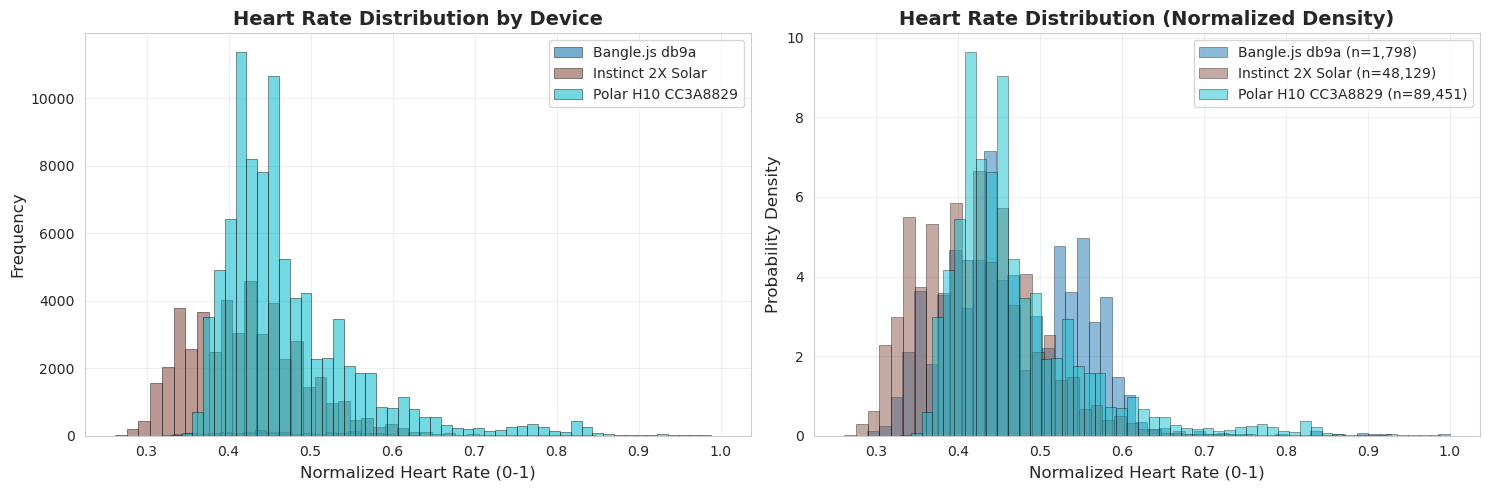

In [135]:
#!/usr/bin/env python3
"""
Heart Rate Distribution Histograms
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
BINS = 50
FIGSIZE = (15, 5)

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
    
    devices = sorted(hr_data['device_name'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))
    
    # Select column
    hr_column = 'HR_NORMALIZED' if NORMALIZED and 'HR_NORMALIZED' in hr_data.columns else 'HEART_RATE'
    xlabel = 'Normalized Heart Rate (0-1)' if NORMALIZED else 'Heart Rate (bpm)'
    
    # Left: Individual histograms (stacked)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        axes[0].hist(device_data, bins=BINS, alpha=0.6, label=device, 
                    color=color, edgecolor='black', linewidth=0.5)
    
    axes[0].set_title('Heart Rate Distribution by Device', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Density plots (normalized for comparison)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        n_samples = len(device_data)
        axes[1].hist(device_data, bins=BINS, alpha=0.5, 
                    label=f'{device} (n={n_samples:,})', 
                    color=color, edgecolor='black', linewidth=0.5,
                    density=True)
    
    axes[1].set_title('Heart Rate Distribution (Normalized Density)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(xlabel, fontsize=12)
    axes[1].set_ylabel('Probability Density', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

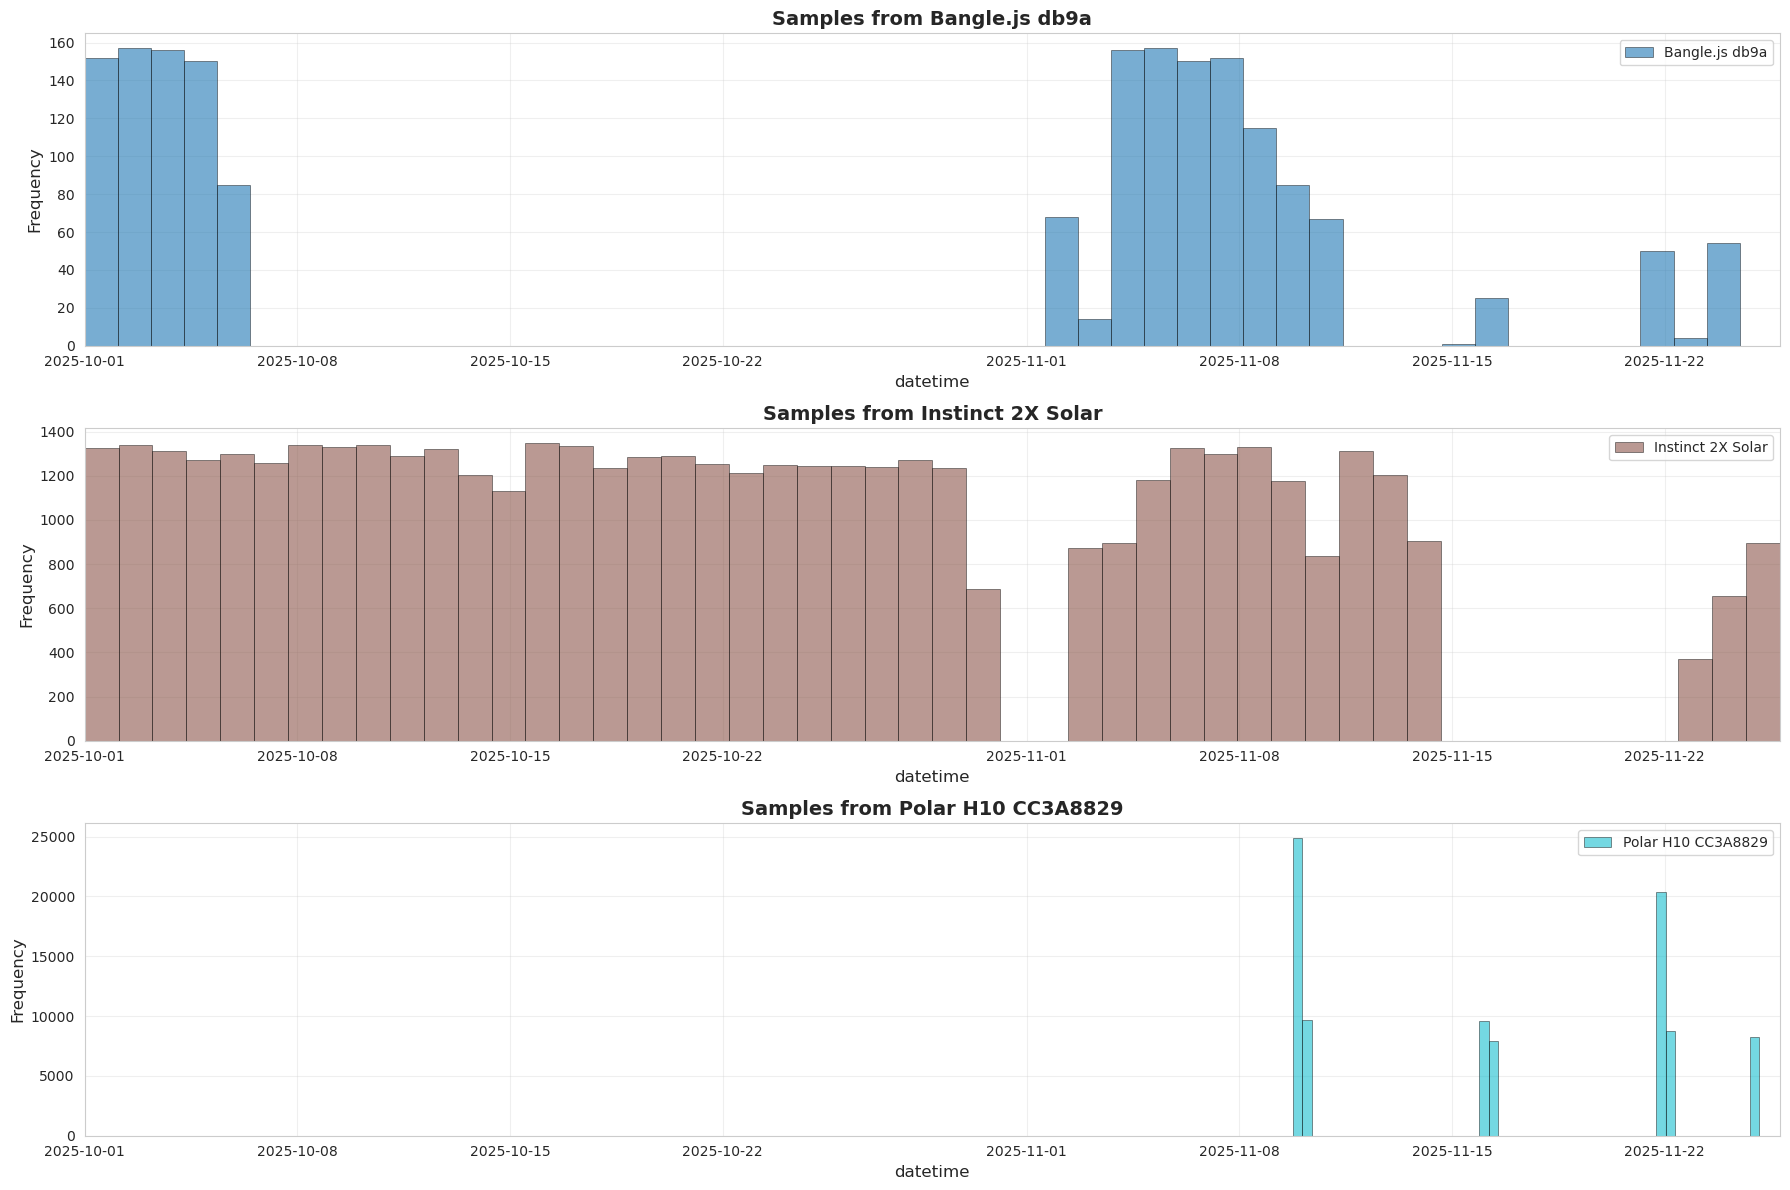

In [136]:
#!/usr/bin/env python3
"""
Heart Rate Distribution Histograms
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
BINS = 50
FIGSIZE = (18, 12)

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    ndevices = len(devices)
    devices = sorted(hr_data['device_name'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, ndevices))
    fig, axes = plt.subplots(ndevices, 1, figsize=FIGSIZE)
    
    # Select column
    dt_column = 'datetime'
    xlabel = 'datetime'
    xmin = hr_data['datetime'].min()    
    xmax = hr_data['datetime'].max()

    # Left: Individual histograms (stacked)
    for device, color, n in zip(devices, colors, range(0,ndevices)):
        device_data = hr_data[hr_data['device_name'] == device][dt_column]
        axes[n].hist(device_data, bins=BINS, alpha=0.6, label=device, 
                    color=color, edgecolor='black', linewidth=0.5)
    
        axes[n].set_title(f'Samples from {device}', fontsize=14, fontweight='bold')
        axes[n].set_xlabel(xlabel, fontsize=12)
        axes[n].set_xlim([xmin,xmax])
        axes[n].set_ylabel('Frequency', fontsize=12)
        axes[n].legend()
        axes[n].grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

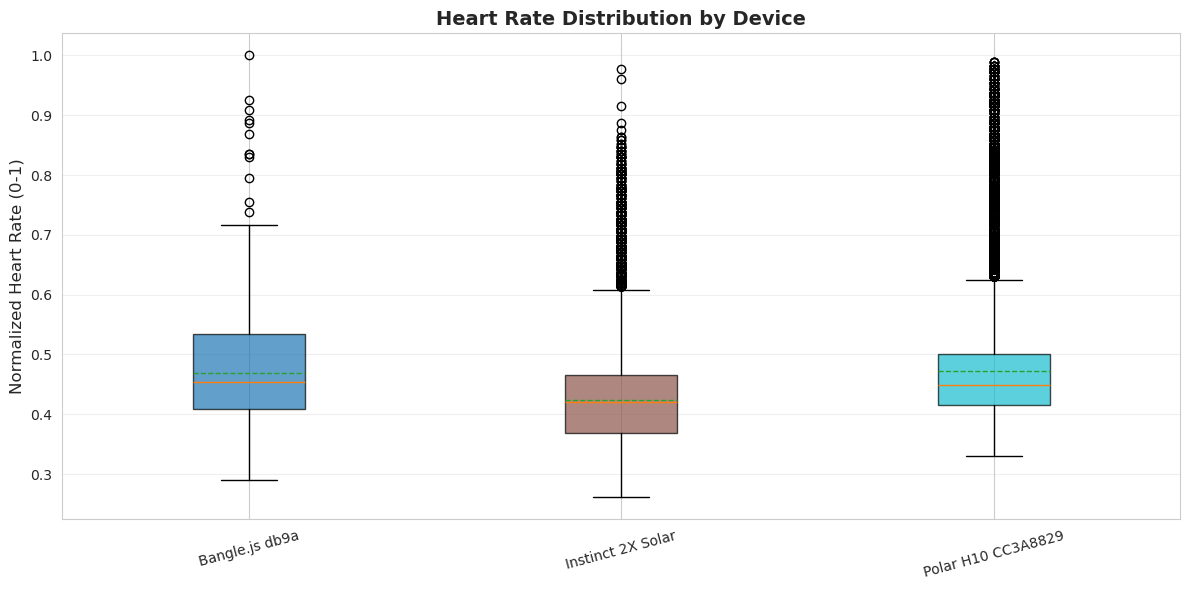

BOX PLOT STATISTICS

Bangle.js db9a:
  Min: 0.29
  Q1 (25%): 0.41
  Median: 0.45
  Q3 (75%): 0.53
  Max: 1.00
  IQR: 0.12
  Outliers: 12 (0.7%)

Instinct 2X Solar:
  Min: 0.26
  Q1 (25%): 0.37
  Median: 0.42
  Q3 (75%): 0.47
  Max: 0.98
  IQR: 0.10
  Outliers: 792 (1.6%)

Polar H10 CC3A8829:
  Min: 0.33
  Q1 (25%): 0.41
  Median: 0.45
  Q3 (75%): 0.50
  Max: 0.99
  IQR: 0.09
  Outliers: 5256 (5.9%)


In [137]:
#!/usr/bin/env python3
"""
Heart Rate Box Plots
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
FIGSIZE = (12, 6)

# =============================================================================
# PLOT BOX PLOTS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    devices = sorted(hr_data['device_name'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))
    
    # Select column
    hr_column = 'HR_NORMALIZED' if NORMALIZED and 'HR_NORMALIZED' in hr_data.columns else 'HEART_RATE'
    ylabel = 'Normalized Heart Rate (0-1)' if NORMALIZED else 'Heart Rate (bpm)'
    
    # Prepare data for box plot
    data_for_box = [hr_data[hr_data['device_name'] == d][hr_column].values for d in devices]
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    
    bp = ax.boxplot(data_for_box, tick_labels=devices, patch_artist=True,
                   showmeans=True, meanline=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Style the plot
    ax.set_title('Heart Rate Distribution by Device', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("="*80)
    print("BOX PLOT STATISTICS")
    print("="*80)
    for device in devices:
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        q1, q2, q3 = device_data.quantile([0.25, 0.5, 0.75])
        iqr = q3 - q1
        lower_whisker = max(device_data.min(), q1 - 1.5 * iqr)
        upper_whisker = min(device_data.max(), q3 + 1.5 * iqr)
        outliers = ((device_data < lower_whisker) | (device_data > upper_whisker)).sum()
        
        print(f"\n{device}:")
        print(f"  Min: {device_data.min():.2f}")
        print(f"  Q1 (25%): {q1:.2f}")
        print(f"  Median: {q2:.2f}")
        print(f"  Q3 (75%): {q3:.2f}")
        print(f"  Max: {device_data.max():.2f}")
        print(f"  IQR: {iqr:.2f}")
        print(f"  Outliers: {outliers} ({outliers/len(device_data)*100:.1f}%)")

CORRELATION ANALYSIS (vs Polar H10 CC3A8829)

Instinct 2X Solar:
  Paired samples: 595
  Correlation (R): 0.692
  R²: 0.479
  MAE: 0.03 bpm
  RMSE: 0.04 bpm
  Mean difference: -0.02 bpm

Bangle.js db9a:
  Paired samples: 117
  Correlation (R): 0.395
  R²: 0.156
  MAE: 0.05 bpm
  RMSE: 0.08 bpm
  Mean difference: 0.01 bpm


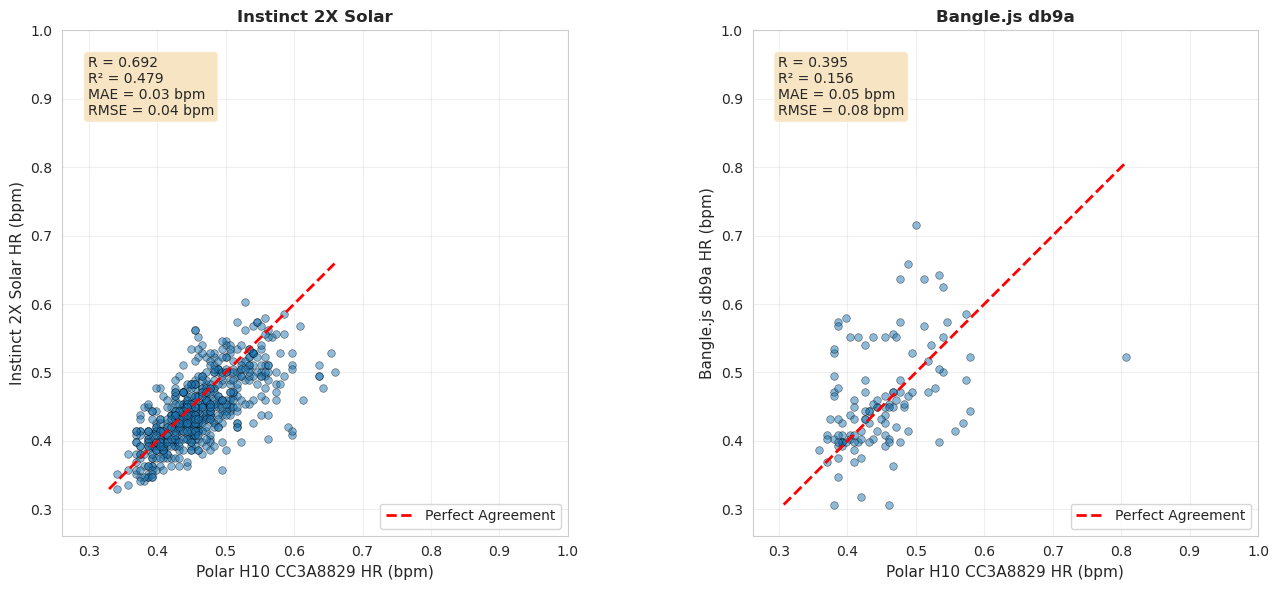

In [138]:
#!/usr/bin/env python3
"""
Device HR Correlation Scatter Plots
Shows how well each device correlates with reference device
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
REFERENCE_DEVICE = 'Polar H10 CC3A8829'  # Reference device (gold standard)
TOLERANCE_SECONDS = 60  # Max time difference for matching measurements
FIGSIZE_PER_DEVICE = 7
PLOT_RANGE = [hr_data['HR_NORMALIZED'].min(),hr_data['HR_NORMALIZED'].max()]

# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    # Try to find reference device
    polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
    
    if polar_data.empty:
        polar_matches = hr_data[hr_data['device_name'].str.contains('Polar', case=False, na=False)]
        if not polar_matches.empty:
            REFERENCE_DEVICE = polar_matches['device_name'].iloc[0]
            polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
            print(f"Using reference device: {REFERENCE_DEVICE}")
    
    if polar_data.empty:
        print(f"Error: Reference device not found in data")
        print(f"Available devices: {list(hr_data['device_name'].unique())}")
    else:
        polar_data = polar_data[['datetime', 'HR_NORMALIZED']].copy()
        polar_data.columns = ['datetime', 'polar_hr']
        
        other_devices = [d for d in hr_data['device_name'].unique() if d != REFERENCE_DEVICE]
        
        if not other_devices:
            print("Error: Need at least one other device for comparison")
        else:
            n_devices = len(other_devices)
            fig, axes = plt.subplots(1, n_devices, figsize=(FIGSIZE_PER_DEVICE*n_devices, 6))
            
            if n_devices == 1:
                axes = [axes]
            
            print("="*80)
            print(f"CORRELATION ANALYSIS (vs {REFERENCE_DEVICE})")
            print("="*80)
            
            for idx, device in enumerate(other_devices):
                device_data = hr_data[hr_data['device_name'] == device][['datetime', 'HR_NORMALIZED']].copy()
                device_data.columns = ['datetime', 'device_hr']
                
                # Merge on nearest timestamps
                merged = pd.merge_asof(
                    device_data.sort_values('datetime'),
                    polar_data.sort_values('datetime'),
                    on='datetime',
                    direction='nearest',
                    tolerance=pd.Timedelta(f'{TOLERANCE_SECONDS}s')
                ).dropna()
                
                if not merged.empty:
                    axes[idx].scatter(merged['polar_hr'], merged['device_hr'], 
                                     alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
                    
                    # Plot perfect agreement line
                    min_val = min(merged['polar_hr'].min(), merged['device_hr'].min())
                    max_val = max(merged['polar_hr'].max(), merged['device_hr'].max())
                    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                                  'r--', linewidth=2, label='Perfect Agreement')
                    
                    # Calculate statistics
                    correlation = merged['polar_hr'].corr(merged['device_hr'])
                    mae = np.abs(merged['device_hr'] - merged['polar_hr']).mean()
                    rmse = np.sqrt(((merged['device_hr'] - merged['polar_hr']) ** 2).mean())
                    
                    # Display stats on plot
                    stats_text = f'R = {correlation:.3f}\nR² = {correlation**2:.3f}\nMAE = {mae:.2f} bpm\nRMSE = {rmse:.2f} bpm'
                    axes[idx].text(0.05, 0.95, stats_text,
                                  transform=axes[idx].transAxes, 
                                  verticalalignment='top',
                                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                                  fontsize=10)
                    
                    axes[idx].set_xlabel(f'{REFERENCE_DEVICE} HR (bpm)', fontsize=11)
                    axes[idx].set_ylabel(f'{device} HR (bpm)', fontsize=11)
                    axes[idx].set_xlim(PLOT_RANGE)
                    axes[idx].set_ylim(PLOT_RANGE)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    axes[idx].legend(loc='lower right')
                    axes[idx].grid(True, alpha=0.3)
                    axes[idx].set_aspect('equal', adjustable='box')
                    
                    # Print statistics
                    print(f"\n{device}:")
                    print(f"  Paired samples: {len(merged):,}")
                    print(f"  Correlation (R): {correlation:.3f}")
                    print(f"  R²: {correlation**2:.3f}")
                    print(f"  MAE: {mae:.2f} bpm")
                    print(f"  RMSE: {rmse:.2f} bpm")
                    print(f"  Mean difference: {(merged['device_hr'] - merged['polar_hr']).mean():.2f} bpm")
                else:
                    axes[idx].text(0.5, 0.5, f'No overlapping data\nwith {REFERENCE_DEVICE}',
                                  ha='center', va='center', transform=axes[idx].transAxes,
                                  fontsize=12)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    print(f"\n{device}: No overlapping data within {TOLERANCE_SECONDS}s")
            
            plt.tight_layout()
            plt.show()

In [139]:
# %% [markdown]
# # HRM Calibration Model for Bangle.js 2
# Train ML model to improve Bangle.js 2 HRM using Garmin/Polar reference data

# %% Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import os

ALIGNMENT_TOLERANCE = '0.1s'  # adjust if needed

sns.set_style('whitegrid')

# ## Step 1: Split by Device Type

bangle_df = hr_data[hr_data['device_type'].str.contains('BANGLE', case=False, na=False)].copy()
reference_df = hr_data[hr_data['device_type'].str.contains('GARMIN|POLAR', case=False, na=False)].copy()

print(f"Bangle.js data: {len(bangle_df):,} measurements")
print(f"Reference data: {len(reference_df):,} measurements")
print(f"  - Garmin: {len(reference_df[reference_df['device_type'].str.contains('GARMIN', case=False)])}")
print(f"  - Polar: {len(reference_df[reference_df['device_type'].str.contains('POLAR', case=False)])}")

# %% [markdown]
# ## Step 2: Time Alignment Using merge_asof

# Sort both dataframes
bangle_df = bangle_df.sort_values('datetime')
reference_df = reference_df.sort_values('datetime')

# Merge using nearest datetime, handling duplicates safely
aligned_data = pd.merge_asof(
    bangle_df,
    reference_df[['datetime','HEART_RATE']].rename(columns={'HEART_RATE':'HRREF'}),
    on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta(ALIGNMENT_TOLERANCE)
)

# Remove duplicate reference timestamps (required for interpolation)
reference_df = reference_df.drop_duplicates(subset='datetime')

# Set reference datetime as index for interpolation
reference_interp = reference_df.set_index('datetime')['HEART_RATE'].sort_index().reindex(
    pd.date_range(reference_df['datetime'].min(), reference_df['datetime'].max(), freq='0.1s')
).interpolate('linear')

# Map interpolated reference HR to Bangle timestamps
bangle_df['HRREF'] = bangle_df['datetime'].map(reference_interp)

# Drop any rows where interpolation failed
aligned_data = bangle_df.dropna(subset=['HRREF']).copy()

aligned_data = aligned_data.dropna(subset=['HRREF'])
print(f"✓ Aligned {len(aligned_data):,} data points with tolerance={ALIGNMENT_TOLERANCE}")


Bangle.js data: 1,798 measurements
Reference data: 137,580 measurements
  - Garmin: 48129
  - Polar: 89451
✓ Aligned 1,798 data points with tolerance=0.1s


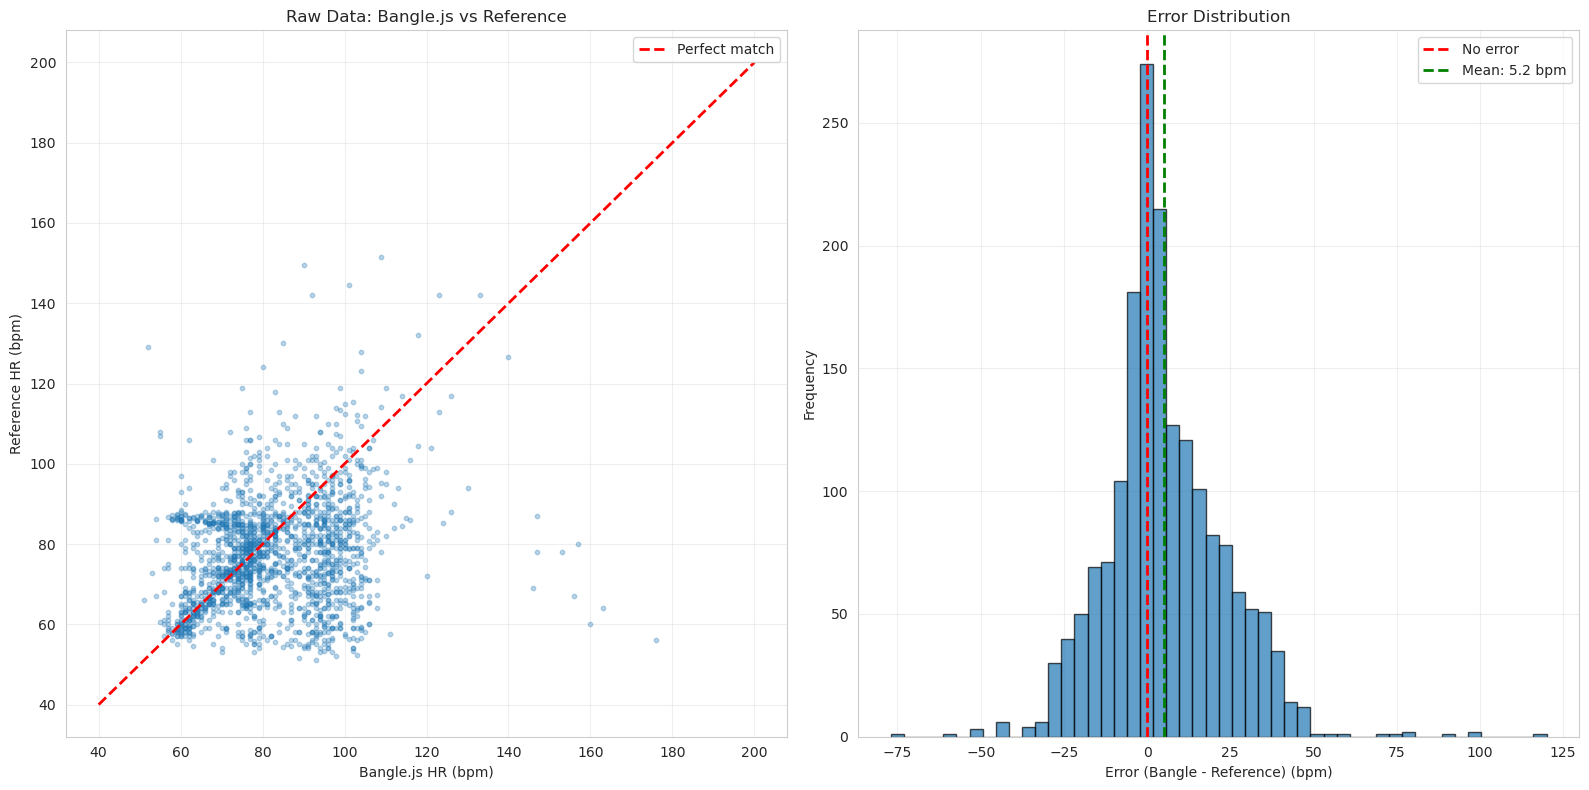

In [140]:
# %% Visualize alignment quality
fig, axes = plt.subplots(1,2,figsize=(16,8))

# Scatter
axes[0].scatter(aligned_data['HEART_RATE'], aligned_data['HRREF'], alpha=0.3, s=10)
axes[0].plot([40,200],[40,200],'r--', lw=2, label='Perfect match')
axes[0].set_xlabel('Bangle.js HR (bpm)')
axes[0].set_ylabel('Reference HR (bpm)')
axes[0].set_title('Raw Data: Bangle.js vs Reference')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error histogram
error = aligned_data['HEART_RATE'] - aligned_data['HRREF']
axes[1].hist(error, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0,color='r', linestyle='--', lw=2, label='No error')
axes[1].axvline(error.mean(),color='g', linestyle='--', lw=2, label=f'Mean: {error.mean():.1f} bpm')
axes[1].set_xlabel('Error (Bangle - Reference) (bpm)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [141]:
# %% [markdown]
# ## Step 3: Feature Engineering
raw_mae = mean_absolute_error(aligned_data['HRREF'], aligned_data['HEART_RATE'])
print(f"Baseline MAE (before calibration): {raw_mae:.2f} bpm")

aligned_data['hrm_raw'] = aligned_data['HEART_RATE']
aligned_data['hrm_diff_1'] = aligned_data['hrm_raw'].diff(1)
aligned_data['hrm_diff_5'] = aligned_data['hrm_raw'].diff(5)
aligned_data['hrm_rolling_mean_5'] = aligned_data['hrm_raw'].rolling(window=5, min_periods=1).mean()
aligned_data['hrm_rolling_std_5'] = aligned_data['hrm_raw'].rolling(window=5, min_periods=1).std()
aligned_data = aligned_data.bfill().ffill()

# %% [markdown]
# ## Step 4: Prepare Training Data

feature_cols = ['hrm_raw','hrm_diff_1','hrm_diff_5','hrm_rolling_mean_5','hrm_rolling_std_5']
X = aligned_data[feature_cols].copy()
y = aligned_data['HRREF'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %% [markdown]
# ## Step 5: Train & Evaluate Models

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Random Forest
rf = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

# Polynomial Regression (simple)
simple_features = ['hrm_raw','hrm_rolling_mean_5']
X_simple = X_train[simple_features]
X_test_simple = X_test[simple_features]
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X_simple)
X_test_poly = poly.transform(X_test_simple)

poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

# %% [markdown]
# ## Step 6: Compare Models

results_df = pd.DataFrame({
    'Model':['Baseline','Ridge','Random Forest','Gradient Boosting','Polynomial'],
    'MAE (bpm)':[raw_mae,mae_ridge,mae_rf,mae_gb,mae_poly],
    'RMSE (bpm)':[np.nan,rmse_ridge,rmse_rf,rmse_gb,rmse_poly],
    'R²':[np.nan,r2_ridge,r2_rf,r2_gb,r2_poly]
})
print(results_df)

# %% [markdown]
# ## Step 7: Export Best Model & Lookup Table

# Determine best
mae_list = [mae_ridge, mae_rf, mae_gb, mae_poly]
best_idx = np.argmin(mae_list)
best_model_name = ['Ridge','Random Forest','Gradient Boosting','Polynomial'][best_idx]
best_model = [ridge,rf,gb,poly_model][best_idx]

best_features = feature_cols if best_model_name != 'Polynomial' else simple_features

os.makedirs('models', exist_ok=True)

if best_model_name == 'Polynomial':
    joblib.dump(poly, 'models/poly_transformer.pkl')

model_package = {
    'model': best_model,
    'scaler': scaler if best_model_name=='Ridge' else None,
    'feature_names': best_features,
    'model_name': best_model_name,
    'mae': mae_list[best_idx]
}
joblib.dump(model_package,'models/hrm_calibration_model.pkl')

# Simple lookup table
lookup_bins = np.arange(40,200,5)
lookup_table = []
for i in range(len(lookup_bins)-1):
    bin_min = lookup_bins[i]
    bin_max = lookup_bins[i+1]
    mask = (aligned_data['hrm_raw']>=bin_min)&(aligned_data['hrm_raw']<bin_max)
    if mask.sum()>0:
        avg_corr = (aligned_data.loc[mask,'HRREF'] - aligned_data.loc[mask,'hrm_raw']).mean()
        lookup_table.append({'hr_min':int(bin_min),'hr_max':int(bin_max),'correction':round(float(avg_corr),2)})

with open('models/hrm_calibration_lookup.json','w') as f:
    json.dump(lookup_table,f,indent=2)

print(f"✓ Saved models and lookup table in 'models/' directory")


Baseline MAE (before calibration): 13.34 bpm
               Model  MAE (bpm)  RMSE (bpm)        R²
0           Baseline  13.335567         NaN       NaN
1              Ridge  10.412882   13.651427  0.116705
2      Random Forest  10.083301   12.892746  0.212155
3  Gradient Boosting   9.936271   12.785613  0.225194
4         Polynomial  10.409023   13.651389  0.116710
✓ Saved models and lookup table in 'models/' directory


Reference data: 137,580 measurements
Devices: ['GARMIN_INSTINCT_2X_SOLAR' 'POLARH10']
Time range: 2025-10-01 00:00:00 to 2025-11-25 18:59:00
HR range: 46 - 174 bpm


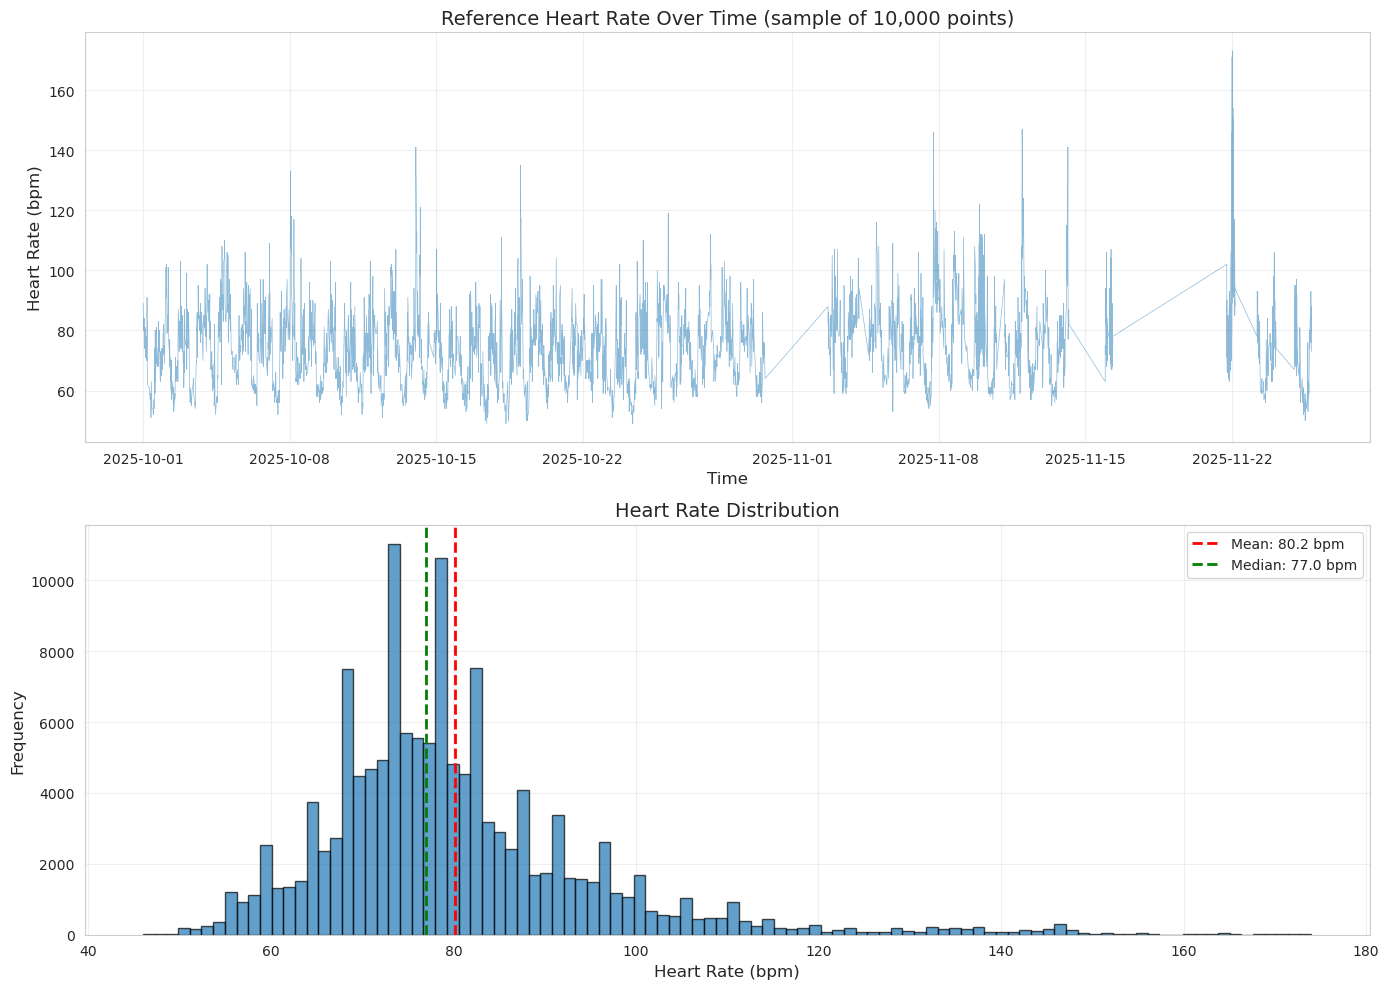

Creating temporal features...

Created 20 features

Top 10 most correlated features:
hr_lag_1            NaN
hr_lag_2            NaN
hr_lag_5            NaN
hr_lag_10           NaN
hr_lag_30           NaN
hr_change_1         NaN
hr_change_5         NaN
hr_accel_1          NaN
hr_rolling_mean_5   NaN
hr_rolling_std_5    NaN
Name: heart_rate, dtype: float64


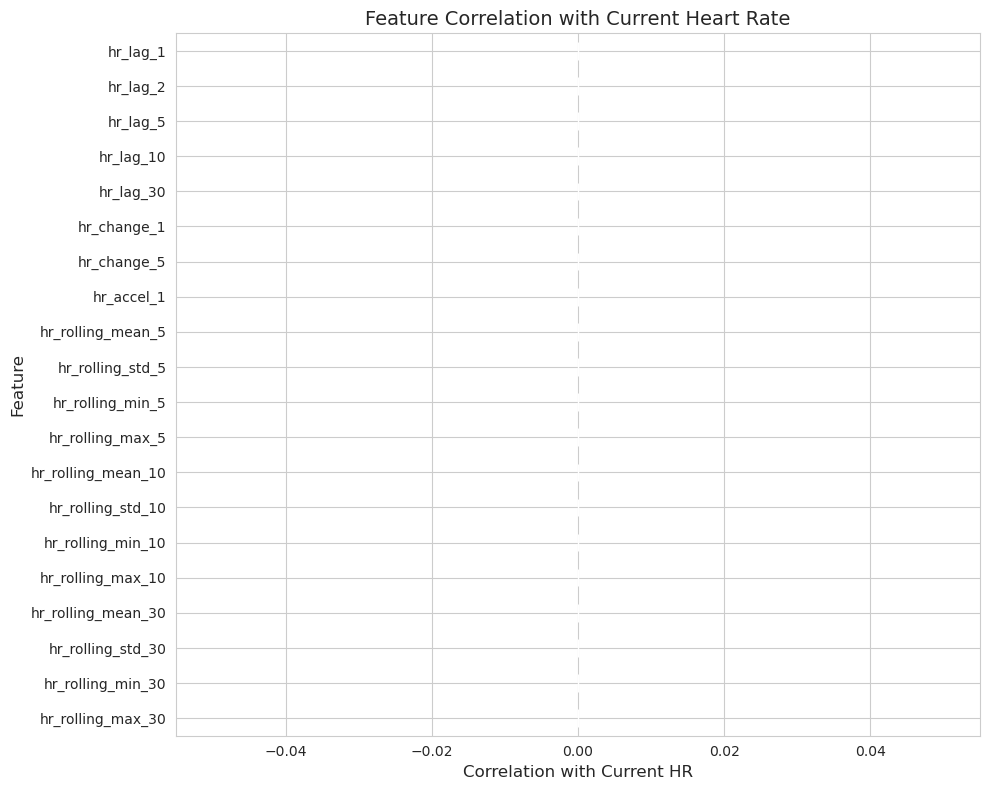

Feature matrix: (0, 20)
Target vector: (0,)

Training set: 0 samples
Test set: 0 samples

Training Ridge Regression...


ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by StandardScaler.

In [142]:
# %% [markdown]
# # Personal Heart Rate Dynamics Model
# Learn how YOUR heart rate changes over time from reference data,
# then use this to improve Bangle.js predictions

# %% Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json

sns.set_style('whitegrid')

# %% [markdown]
# ## Step 1: Prepare Reference Data (Your "Ground Truth" HR Dynamics)

# %% Get reference device data
reference_df = hr_data[
    hr_data['device_type'].str.contains('GARMIN|POLAR', case=False, na=False)
].copy()

reference_df = reference_df.rename(columns={'datetime': 'timestamp', 'HEART_RATE': 'heart_rate'})
reference_df = reference_df.sort_values('timestamp').reset_index(drop=True)

print(f"Reference data: {len(reference_df):,} measurements")
print(f"Devices: {reference_df['device_type'].unique()}")
print(f"Time range: {reference_df['timestamp'].min()} to {reference_df['timestamp'].max()}")
print(f"HR range: {reference_df['heart_rate'].min():.0f} - {reference_df['heart_rate'].max():.0f} bpm")

# %% Visualize reference data
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series plot (sample)
sample_size = min(10000, len(reference_df))
sample_indices = np.random.choice(len(reference_df), sample_size, replace=False)
sample_indices.sort()
sample = reference_df.iloc[sample_indices]

axes[0].plot(sample['timestamp'], sample['heart_rate'], alpha=0.5, linewidth=0.5)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Heart Rate (bpm)', fontsize=12)
axes[0].set_title(f'Reference Heart Rate Over Time (sample of {sample_size:,} points)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Distribution
axes[1].hist(reference_df['heart_rate'], bins=100, edgecolor='black', alpha=0.7)
axes[1].axvline(reference_df['heart_rate'].mean(), color='r', linestyle='--', 
                lw=2, label=f'Mean: {reference_df["heart_rate"].mean():.1f} bpm')
axes[1].axvline(reference_df['heart_rate'].median(), color='g', linestyle='--', 
                lw=2, label=f'Median: {reference_df["heart_rate"].median():.1f} bpm')
axes[1].set_xlabel('Heart Rate (bpm)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Heart Rate Distribution', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 2: Create Time-Series Features
# Build features that capture how HR changes over time

# %% Create temporal features for dynamics modeling
def create_temporal_features(df, lookback_steps=[1, 2, 5, 10, 30]):
    """
    Create features that capture HR dynamics using ONLY past information.
    This prevents data leakage by ensuring features don't include the current value.
    """
    df = df.copy()
    
    # CRITICAL: All features must use .shift() to ensure we only use PAST data
    
    # Lookback features - previous HR values
    for step in lookback_steps:
        df[f'hr_lag_{step}'] = df['heart_rate'].shift(step)
    
    # Rate of change features (using past values)
    df['hr_change_1'] = df['heart_rate'].shift(1) - df['heart_rate'].shift(2)
    df['hr_change_5'] = df['heart_rate'].shift(1) - df['heart_rate'].shift(6)
    
    # Acceleration (rate of change of rate of change)
    df['hr_accel_1'] = df['hr_change_1'].shift(1) - df['hr_change_1'].shift(2)
    
    # Rolling statistics using PAST data only (exclude current value)
    for window in [5, 10, 30]:
        # Shift by 1 to exclude current value, then compute rolling stats
        df[f'hr_rolling_mean_{window}'] = df['heart_rate'].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'hr_rolling_std_{window}'] = df['heart_rate'].shift(1).rolling(window=window, min_periods=1).std()
        df[f'hr_rolling_min_{window}'] = df['heart_rate'].shift(1).rolling(window=window, min_periods=1).min()
        df[f'hr_rolling_max_{window}'] = df['heart_rate'].shift(1).rolling(window=window, min_periods=1).max()
    
    # Drop initial rows where we don't have enough lookback data
    df = df.dropna()
    
    return df

print("Creating temporal features...")
reference_df = create_temporal_features(reference_df)

# Show feature correlation with current HR
feature_cols = [col for col in reference_df.columns if col.startswith(('hr_lag_', 'hr_change_', 
                                                                        'hr_accel_', 'hr_rolling_'))]
print(f"\nCreated {len(feature_cols)} features")

# %% Analyze feature importance via correlation
correlations = reference_df[feature_cols + ['heart_rate']].corr()['heart_rate'].drop('heart_rate').sort_values(ascending=False)

print("\nTop 10 most correlated features:")
print(correlations.head(10))

plt.figure(figsize=(10, 8))
correlations.head(20).plot(kind='barh')
plt.xlabel('Correlation with Current HR', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Correlation with Current Heart Rate', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 3: Train Heart Rate Dynamics Model

# %% [markdown]
# ## Step 3: Train Heart Rate Dynamics Model

# %% Prepare training data
# Target: predict current HR from past HR
X = reference_df[feature_cols].copy()
y = reference_df['heart_rate'].copy()

print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y.shape}")

# SPEED UP: Sample data if dataset is huge
MAX_TRAIN_SAMPLES = 500000  # Adjust this - more = better but slower
if len(X) > MAX_TRAIN_SAMPLES:
    print(f"\n⚡ Dataset is large ({len(X):,} samples). Sampling {MAX_TRAIN_SAMPLES:,} for faster training...")
    sample_indices = np.random.choice(len(X), MAX_TRAIN_SAMPLES, replace=False)
    sample_indices.sort()  # Keep temporal order
    X = X.iloc[sample_indices]
    y = y.iloc[sample_indices]
    print(f"   Using {len(X):,} samples for training")

# For final evaluation, use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# %% Train Ridge Regression
print("\nTraining Ridge Regression...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"MAE: {mae_ridge:.2f} bpm, RMSE: {rmse_ridge:.2f} bpm, R²: {r2_ridge:.3f}")

# %% Train Random Forest (with speed optimizations)
print("Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=50,      # Reduced from 100
    max_depth=10,         # Reduced from 15 for speed
    min_samples_split=10, # Larger = faster
    random_state=42, 
    n_jobs=-1,            # Use all CPU cores
    verbose=1             # Show progress
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae_rf:.2f} bpm, RMSE: {rmse_rf:.2f} bpm, R²: {r2_rf:.3f}")

# %% Train Gradient Boosting (with speed optimizations)
print("Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=50,      # Reduced from 100
    max_depth=4,          # Reduced from 5
    subsample=0.5,        # Use only 50% of data per tree for speed
    random_state=42,
    verbose=1             # Show progress
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"MAE: {mae_gb:.2f} bpm, RMSE: {rmse_gb:.2f} bpm, R²: {r2_gb:.3f}")

# %% Compare models
results_df = pd.DataFrame({
    'Model': ['Ridge', 'Random Forest', 'Gradient Boosting'],
    'MAE (bpm)': [mae_ridge, mae_rf, mae_gb],
    'RMSE (bpm)': [rmse_ridge, rmse_rf, rmse_gb],
    'R² Score': [r2_ridge, r2_rf, r2_gb]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))

# %% Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Ridge', y_pred_ridge, mae_ridge),
    ('Random Forest', y_pred_rf, mae_rf),
    ('Gradient Boosting', y_pred_gb, mae_gb)
]

for idx, (name, y_pred, mae) in enumerate(models):
    # Scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.3, s=5)
    axes[idx].plot([y_test.min(), y_test.max()], 
                   [y_test.min(), y_test.max()], 
                   'r--', lw=2)
    axes[idx].set_xlabel('Actual HR (bpm)', fontsize=12)
    axes[idx].set_ylabel('Predicted HR (bpm)', fontsize=12)
    axes[idx].set_title(f'{name}\nMAE: {mae:.2f} bpm, R²: {[r2_ridge, r2_rf, r2_gb][idx]:.3f}', fontsize=14)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% Visualize time-series prediction
# Show a sample window of predictions
sample_start = len(y_test) // 2
sample_end = sample_start + 200

fig, ax = plt.subplots(figsize=(14, 6))

x_axis = range(sample_start, sample_end)
ax.plot(x_axis, y_test.iloc[sample_start:sample_end], 'b-', label='Actual HR', linewidth=2)
ax.plot(x_axis, y_pred_gb[sample_start:sample_end], 'r--', label='Predicted HR (GB)', linewidth=2, alpha=0.7)

ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('Heart Rate (bpm)', fontsize=12)
ax.set_title('Heart Rate Prediction Over Time (Sample Window)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% Feature importance
best_model_idx = np.argmin([mae_ridge, mae_rf, mae_gb])
best_model_name = ['Ridge', 'Random Forest', 'Gradient Boosting'][best_model_idx]
best_model = [ridge, rf, gb][best_model_idx]

print(f"\nBest model: {best_model_name}")

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top 20 Features ({best_model_name})', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 most important features:")
    print(importance_df.head(10).to_string(index=False))

# %% [markdown]
# ## Step 4: Apply to Bangle.js Data

# %% Prepare Bangle.js data
bangle_df = hr_data[hr_data['device_type'].str.contains('BANGLE', case=False, na=False)].copy()
bangle_df = bangle_df.rename(columns={'datetime': 'timestamp', 'HEART_RATE': 'heart_rate'})
bangle_df = bangle_df.sort_values('timestamp').reset_index(drop=True)

print(f"Bangle.js data: {len(bangle_df):,} measurements")

# Create same features
bangle_df = create_temporal_features(bangle_df)

# %% Apply dynamics model to Bangle.js
X_bangle = bangle_df[feature_cols].copy()

if best_model_name == 'Ridge':
    X_bangle_scaled = scaler.transform(X_bangle)
    bangle_predictions = best_model.predict(X_bangle_scaled)
else:
    bangle_predictions = best_model.predict(X_bangle)

bangle_df['hr_predicted'] = bangle_predictions
bangle_df['hr_correction'] = bangle_predictions - bangle_df['heart_rate']

print(f"\nBangle.js predictions generated!")
print(f"Mean correction: {bangle_df['hr_correction'].mean():.2f} bpm")
print(f"Std correction: {bangle_df['hr_correction'].std():.2f} bpm")

# %% Visualize Bangle.js corrections
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original vs corrected
sample_size = min(500, len(bangle_df))
sample = bangle_df.iloc[:sample_size]

axes[0, 0].plot(sample['timestamp'], sample['heart_rate'], label='Raw Bangle.js', alpha=0.7)
axes[0, 0].plot(sample['timestamp'], sample['hr_predicted'], label='Corrected (Model)', alpha=0.7)
axes[0, 0].set_xlabel('Time', fontsize=12)
axes[0, 0].set_ylabel('Heart Rate (bpm)', fontsize=12)
axes[0, 0].set_title('Raw vs Model-Corrected Heart Rate', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Correction distribution
axes[0, 1].hist(bangle_df['hr_correction'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].axvline(bangle_df['hr_correction'].mean(), color='g', linestyle='--', lw=2,
                   label=f'Mean: {bangle_df["hr_correction"].mean():.1f} bpm')
axes[0, 1].set_xlabel('Correction (bpm)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Corrections', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Correction vs raw HR
axes[1, 0].scatter(bangle_df['heart_rate'], bangle_df['hr_correction'], alpha=0.3, s=5)
axes[1, 0].axhline(0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Raw Bangle.js HR (bpm)', fontsize=12)
axes[1, 0].set_ylabel('Correction (bpm)', fontsize=12)
axes[1, 0].set_title('Correction vs Raw Heart Rate', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# HR distributions
axes[1, 1].hist(bangle_df['heart_rate'], bins=50, alpha=0.5, label='Raw Bangle.js', edgecolor='black')
axes[1, 1].hist(bangle_df['hr_predicted'], bins=50, alpha=0.5, label='Corrected', edgecolor='black')
axes[1, 1].set_xlabel('Heart Rate (bpm)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('HR Distribution: Raw vs Corrected', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 5: Export Model

# %%
import os
os.makedirs('models', exist_ok=True)

# Save model
model_package = {
    'model': best_model,
    'scaler': scaler if best_model_name == 'Ridge' else None,
    'feature_names': feature_cols,
    'model_name': best_model_name,
    'mae': [mae_ridge, mae_rf, mae_gb][best_model_idx],
    'rmse': [rmse_ridge, rmse_rf, rmse_gb][best_model_idx],
    'r2': [r2_ridge, r2_rf, r2_gb][best_model_idx]
}

joblib.dump(model_package, 'models/hr_dynamics_model.pkl')
print(f"✓ Saved model: models/hr_dynamics_model.pkl")

# Save metadata
metadata = {
    'model_type': 'hr_dynamics',
    'model_name': best_model_name,
    'features': feature_cols,
    'mae_bpm': float(model_package['mae']),
    'rmse_bpm': float(model_package['rmse']),
    'r2_score': float(model_package['r2']),
    'training_samples': int(len(X_train)),
    'description': 'Predicts current HR from recent HR history and dynamics'
}

with open('models/hr_dynamics_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Saved metadata: models/hr_dynamics_metadata.json")

# %% Export corrected Bangle.js data
bangle_export = bangle_df[['timestamp', 'heart_rate', 'hr_predicted', 'hr_correction']].copy()
bangle_export.columns = ['timestamp', 'hr_raw', 'hr_corrected', 'correction_applied']
bangle_export.to_csv('bangle_corrected_hr.csv', index=False)
print(f"✓ Saved corrected data: bangle_corrected_hr.csv")

# %% Usage instructions
print("\n" + "="*70)
print("DEPLOYMENT GUIDE")
print("="*70)
print("""
This model learns YOUR personal heart rate dynamics from reference data.
It predicts what your HR should be based on recent HR history.

HOW IT WORKS:
1. Collects last N heart rate readings from Bangle.js
2. Computes rolling statistics and rate of change
3. Predicts current HR using learned dynamics
4. Can smooth noisy Bangle.js readings

DEPLOYMENT OPTIONS:

A) REAL-TIME ON BANGLE.JS:
   - Keep buffer of last 30 HR readings
   - Compute features (rolling means, changes, etc.)
   - Apply model to predict/smooth current HR
   - Lightweight models (Ridge) work best for embedded

B) POST-PROCESSING:
   - Collect raw Bangle.js data
   - Apply model offline to clean/correct readings
   - Use for historical data analysis

C) HYBRID APPROACH:
   - Use dynamics model for smoothing
   - Periodically sync with reference device to recalibrate

Key insight: This model knows how YOUR HR naturally changes.
If Bangle.js gives a noisy/wrong reading, the model can detect
it doesn't follow your typical patterns and correct it.

Best results when Bangle.js is roughly correct most of the time,
but has occasional noise/errors the model can smooth out.
""")

print(f"Model Performance on Reference Data:")
print(f"  MAE: {model_package['mae']:.2f} bpm")
print(f"  RMSE: {model_package['rmse']:.2f} bpm")
print(f"  R²: {model_package['r2']:.3f}")
print(f"\nThis means the model can predict your HR with ~{model_package['mae']:.1f} bpm error")
print(f"based solely on recent HR history.")

In [ ]:
# %% [markdown]
# ## Interactive Model Tuner
# Use sliders to explore performance vs complexity trade-offs

# %% Interactive Model Tuning UI
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

class HRModelTuner:
    def __init__(self, X_train, y_train, X_test, y_test, all_features):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.all_features = all_features
        
        # Categorize features
        self.lag_features = sorted([f for f in all_features if 'lag' in f], 
                                   key=lambda x: int(x.split('_')[-1]))
        self.change_features = sorted([f for f in all_features if 'change' in f or 'accel' in f],
                                     key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0)
        self.rolling_mean_features = sorted([f for f in all_features if 'rolling_mean' in f],
                                           key=lambda x: int(x.split('_')[-1]))
        self.rolling_stat_features = sorted([f for f in all_features if 'rolling_std' in f or 'rolling_min' in f or 'rolling_max' in f],
                                           key=lambda x: int(x.split('_')[-1]))
        
        # Cache for trained models
        self.model_cache = {}
        
        # Create UI
        self.create_ui()
        
    def create_ui(self):
        # Sliders for feature selection
        self.num_lags_slider = widgets.IntSlider(
            value=min(3, len(self.lag_features)), 
            min=0, 
            max=len(self.lag_features),
            description='Lag Features:',
            style={'description_width': '150px'},
            continuous_update=False
        )
        
        self.num_changes_slider = widgets.IntSlider(
            value=min(1, len(self.change_features)), 
            min=0, 
            max=len(self.change_features),
            description='Change Features:',
            style={'description_width': '150px'},
            continuous_update=False
        )
        
        self.num_rolling_mean_slider = widgets.IntSlider(
            value=min(2, len(self.rolling_mean_features)), 
            min=0, 
            max=len(self.rolling_mean_features),
            description='Rolling Means:',
            style={'description_width': '150px'},
            continuous_update=False
        )
        
        self.num_rolling_stat_slider = widgets.IntSlider(
            value=0, 
            min=0, 
            max=len(self.rolling_stat_features),
            description='Rolling Stats:',
            style={'description_width': '150px'},
            continuous_update=False
        )
        
        self.alpha_slider = widgets.FloatLogSlider(
            value=1.0, 
            min=-2, 
            max=2, 
            step=0.1,
            description='Regularization:',
            style={'description_width': '150px'},
            continuous_update=False
        )
        
        # Auto-retrain checkbox
        self.auto_retrain = widgets.Checkbox(
            value=True,
            description='Auto-retrain on change'
        )
        
        # Train button
        self.train_button = widgets.Button(
            description='Train Model',
            button_style='success',
            icon='refresh'
        )
        self.train_button.on_click(self.train_model)
        
        # Export button
        self.export_button = widgets.Button(
            description='Export JS Code',
            button_style='primary',
            icon='download'
        )
        self.export_button.on_click(self.export_model)
        
        # Auto-optimize button
        self.optimize_button = widgets.Button(
            description='Auto-Optimize',
            button_style='warning',
            icon='magic'
        )
        self.optimize_button.on_click(self.auto_optimize)
        
        # Target complexity slider for optimization
        self.target_features_slider = widgets.IntSlider(
            value=5,
            min=1,
            max=20,
            description='Target Features:',
            style={'description_width': '150px'},
            continuous_update=False
        )
        
        # Output area
        self.output = widgets.Output()
        
        # Layout
        controls = widgets.VBox([
            widgets.HTML("<h3>⚙️ Feature Selection</h3>"),
            self.num_lags_slider,
            self.num_changes_slider,
            self.num_rolling_mean_slider,
            self.num_rolling_stat_slider,
            widgets.HTML("<h3>🎛️ Model Parameters</h3>"),
            self.alpha_slider,
            widgets.HTML("<br>"),
            self.auto_retrain,
            widgets.HBox([self.train_button, self.export_button]),
            widgets.HTML("<h3>🤖 Auto-Optimization</h3>"),
            self.target_features_slider,
            self.optimize_button
        ], layout=widgets.Layout(width='400px', padding='10px'))
        
        self.ui = widgets.HBox([controls, self.output], 
                               layout=widgets.Layout(border='2px solid #ddd', padding='10px'))
        
        # Set up auto-retrain
        for slider in [self.num_lags_slider, self.num_changes_slider, 
                      self.num_rolling_mean_slider, self.num_rolling_stat_slider,
                      self.alpha_slider]:
            slider.observe(self.on_slider_change, names='value')
        
        self.auto_retrain.observe(self.on_auto_retrain_change, names='value')
        
        # Initial training
        self.train_model(None)
        
    def on_auto_retrain_change(self, change):
        # Auto-retrain is controlled by continuous_update=False on sliders
        pass
    
    def on_slider_change(self, change):
        if self.auto_retrain.value:
            self.train_model(None)
    
    def get_selected_features(self):
        selected = []
        
        # Add lag features (prioritize recent lags)
        if self.num_lags_slider.value > 0:
            selected.extend(self.lag_features[:self.num_lags_slider.value])
        
        # Add change features
        if self.num_changes_slider.value > 0:
            selected.extend(self.change_features[:self.num_changes_slider.value])
        
        # Add rolling means
        if self.num_rolling_mean_slider.value > 0:
            selected.extend(self.rolling_mean_features[:self.num_rolling_mean_slider.value])
        
        # Add rolling stats
        if self.num_rolling_stat_slider.value > 0:
            selected.extend(self.rolling_stat_features[:self.num_rolling_stat_slider.value])
        
        return selected
    
    def train_model(self, button):
        with self.output:
            clear_output(wait=True)
            
            features = self.get_selected_features()
            
            if len(features) == 0:
                print("⚠️ No features selected! Select at least one feature.")
                return
            
            # Create cache key
            cache_key = (tuple(features), self.alpha_slider.value)
            
            # Check cache
            if cache_key in self.model_cache:
                result = self.model_cache[cache_key]
                model = result['model']
                scaler = result['scaler']
                y_pred = result['y_pred']
                train_time = result['train_time']
                cached = True
            else:
                # Train model
                start_time = time.time()
                
                X_train_subset = self.X_train[features]
                X_test_subset = self.X_test[features]
                
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train_subset)
                X_test_scaled = scaler.transform(X_test_subset)
                
                model = Ridge(alpha=self.alpha_slider.value)
                model.fit(X_train_scaled, self.y_train)
                y_pred = model.predict(X_test_scaled)
                
                train_time = time.time() - start_time
                
                # Cache result
                result = {
                    'model': model,
                    'scaler': scaler,
                    'y_pred': y_pred,
                    'train_time': train_time
                }
                self.model_cache[cache_key] = result
                cached = False
            
            # Calculate metrics
            mae = mean_absolute_error(self.y_test, y_pred)
            rmse = np.sqrt(np.mean((self.y_test - y_pred)**2))
            r2 = r2_score(self.y_test, y_pred)
            
            # Calculate buffer size needed
            buffer_size = 0
            for f in features:
                if 'lag' in f or 'rolling' in f or 'change' in f or 'accel' in f:
                    parts = f.split('_')
                    for part in parts:
                        if part.isdigit():
                            buffer_size = max(buffer_size, int(part) + 1)
            
            # Estimate memory
            model_bytes = len(features) * 8 * 2  # coefficients + scaler params (rough estimate)
            
            # Store current model
            self.current_model = model
            self.current_scaler = scaler
            self.current_features = features
            self.current_y_pred = y_pred
            self.current_mae = mae
            
            # Display results
            status = "🔄 CACHED" if cached else "✅ TRAINED"
            print(f"{status} in {train_time:.3f}s | Cache: {len(self.model_cache)} configs")
            print("=" * 70)
            print(f"📊 PERFORMANCE:")
            print(f"  MAE:  {mae:.2f} bpm")
            print(f"  RMSE: {rmse:.2f} bpm")
            print(f"  R²:   {r2:.4f}")
            print()
            print(f"💾 COMPLEXITY:")
            print(f"  Features: {len(features)}")
            print(f"  Buffer size: {buffer_size} HR readings")
            print(f"  Memory: ~{model_bytes:,} bytes")
            print()
            print(f"🔧 SELECTED FEATURES:")
            for i, feat in enumerate(features[:10]):
                print(f"  {i+1}. {feat}")
            if len(features) > 10:
                print(f"  ... and {len(features) - 10} more")
            
            # Plot results
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Scatter plot
            axes[0].scatter(self.y_test, y_pred, alpha=0.3, s=5)
            axes[0].plot([self.y_test.min(), self.y_test.max()], 
                        [self.y_test.min(), self.y_test.max()], 
                        'r--', lw=2)
            axes[0].set_xlabel('Actual HR (bpm)', fontsize=12)
            axes[0].set_ylabel('Predicted HR (bpm)', fontsize=12)
            axes[0].set_title(f'Predictions\nMAE: {mae:.2f} bpm, R²: {r2:.3f}', fontsize=14)
            axes[0].grid(True, alpha=0.3)
            
            # Error distribution
            errors = y_pred - self.y_test
            axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
            axes[1].axvline(0, color='r', linestyle='--', lw=2)
            axes[1].set_xlabel('Prediction Error (bpm)', fontsize=12)
            axes[1].set_ylabel('Frequency', fontsize=12)
            axes[1].set_title(f'Error Distribution\nMean: {errors.mean():.2f} bpm', fontsize=14)
            axes[1].grid(True, alpha=0.3)
            
            # Feature coefficients
            n_show = min(15, len(features))
            coef_df = pd.DataFrame({
                'feature': features,
                'coefficient': model.coef_
            }).sort_values('coefficient', key=abs, ascending=False).head(n_show)
            
            axes[2].barh(coef_df['feature'], coef_df['coefficient'])
            axes[2].set_xlabel('Coefficient', fontsize=12)
            axes[2].set_ylabel('Feature', fontsize=12)
            title = f'Top {n_show} Features' if len(features) > n_show else 'Feature Coefficients'
            axes[2].set_title(title, fontsize=14)
            axes[2].invert_yaxis()
            axes[2].grid(True, alpha=0.3, axis='x')
            
            plt.tight_layout()
            plt.show()
    
    def auto_optimize(self, button):
        """Find the best model configurations across the Pareto frontier"""
        with self.output:
            clear_output(wait=True)
            print("🤖 AUTO-OPTIMIZATION STARTED")
            print("=" * 70)
            print(f"Target: ~{self.target_features_slider.value} features")
            print("Exploring different feature combinations...\n")
            
            # Disable auto-retrain during optimization
            original_auto_retrain = self.auto_retrain.value
            self.auto_retrain.value = False
            
            # Collect results
            results = []
            
            # Strategy: Try different combinations around the target
            target = self.target_features_slider.value
            
            # Generate configurations to test
            configs = []
            
            # Conservative configs (fewer features)
            for n_lags in range(1, min(6, len(self.lag_features) + 1)):
                for n_changes in range(0, min(3, len(self.change_features) + 1)):
                    for n_means in range(0, min(4, len(self.rolling_mean_features) + 1)):
                        total = n_lags + n_changes + n_means
                        if total >= max(1, target - 3) and total <= target + 3:
                            configs.append((n_lags, n_changes, n_means, 0))
            
            # Add some configs with rolling stats
            for n_lags in range(1, min(6, len(self.lag_features) + 1)):
                for n_changes in range(0, min(2, len(self.change_features) + 1)):
                    for n_means in range(0, min(3, len(self.rolling_mean_features) + 1)):
                        for n_stats in range(1, min(3, len(self.rolling_stat_features) + 1)):
                            total = n_lags + n_changes + n_means + n_stats
                            if total >= target and total <= target + 3:
                                configs.append((n_lags, n_changes, n_means, n_stats))
            
            # Remove duplicates
            configs = list(set(configs))
            
            print(f"Testing {len(configs)} configurations...")
            
            # Test each configuration
            for i, (n_lags, n_changes, n_means, n_stats) in enumerate(configs):
                # Update sliders
                self.num_lags_slider.value = n_lags
                self.num_changes_slider.value = n_changes
                self.num_rolling_mean_slider.value = n_means
                self.num_rolling_stat_slider.value = n_stats
                
                features = self.get_selected_features()
                if len(features) == 0:
                    continue
                
                # Train model (will use cache if available)
                cache_key = (tuple(features), self.alpha_slider.value)
                
                if cache_key not in self.model_cache:
                    X_train_subset = self.X_train[features]
                    X_test_subset = self.X_test[features]
                    
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train_subset)
                    X_test_scaled = scaler.transform(X_test_subset)
                    
                    model = Ridge(alpha=self.alpha_slider.value)
                    model.fit(X_train_scaled, self.y_train)
                    y_pred = model.predict(X_test_scaled)
                    
                    self.model_cache[cache_key] = {
                        'model': model,
                        'scaler': scaler,
                        'y_pred': y_pred,
                        'train_time': 0
                    }
                
                result = self.model_cache[cache_key]
                mae = mean_absolute_error(self.y_test, result['y_pred'])
                r2 = r2_score(self.y_test, result['y_pred'])
                
                # Calculate buffer size
                buffer_size = 0
                for f in features:
                    if 'lag' in f or 'rolling' in f or 'change' in f or 'accel' in f:
                        parts = f.split('_')
                        for part in parts:
                            if part.isdigit():
                                buffer_size = max(buffer_size, int(part) + 1)
                
                results.append({
                    'n_features': len(features),
                    'buffer_size': buffer_size,
                    'mae': mae,
                    'r2': r2,
                    'n_lags': n_lags,
                    'n_changes': n_changes,
                    'n_means': n_means,
                    'n_stats': n_stats,
                    'features': features
                })
                
                if (i + 1) % 20 == 0:
                    print(f"  Tested {i + 1}/{len(configs)} configs...")
            
            print(f"✅ Tested {len(results)} valid configurations\n")
            
            # Find Pareto frontier (best MAE for each feature count)
            results_df = pd.DataFrame(results)
            pareto_frontier = []
            
            for n_feat in sorted(results_df['n_features'].unique()):
                subset = results_df[results_df['n_features'] == n_feat]
                best = subset.loc[subset['mae'].idxmin()]
                pareto_frontier.append(best)
            
            pareto_df = pd.DataFrame(pareto_frontier)
            
            # Display results
            print("=" * 70)
            print("🏆 PARETO FRONTIER (Best models by complexity)")
            print("=" * 70)
            print(pareto_df[['n_features', 'buffer_size', 'mae', 'r2']].to_string(index=False))
            
            # Find recommended configuration
            # Score: balance between low MAE and low feature count
            pareto_df['score'] = pareto_df['mae'] * (1 + 0.1 * pareto_df['n_features'])
            best_idx = pareto_df['score'].idxmin()
            recommended = pareto_df.loc[best_idx]
            
            print("\n" + "=" * 70)
            print("✨ RECOMMENDED CONFIGURATION")
            print("=" * 70)
            print(f"Features: {int(recommended['n_features'])}")
            print(f"Buffer: {int(recommended['buffer_size'])} readings")
            print(f"MAE: {recommended['mae']:.2f} bpm")
            print(f"R²: {recommended['r2']:.4f}")
            print(f"\nConfiguration:")
            print(f"  Lags: {int(recommended['n_lags'])}")
            print(f"  Changes: {int(recommended['n_changes'])}")
            print(f"  Rolling Means: {int(recommended['n_means'])}")
            print(f"  Rolling Stats: {int(recommended['n_stats'])}")
            
            # Set sliders to recommended configuration
            self.num_lags_slider.value = int(recommended['n_lags'])
            self.num_changes_slider.value = int(recommended['n_changes'])
            self.num_rolling_mean_slider.value = int(recommended['n_means'])
            self.num_rolling_stat_slider.value = int(recommended['n_stats'])
            
            # Plot Pareto frontier
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # MAE vs Features
            axes[0].plot(pareto_df['n_features'], pareto_df['mae'], 'o-', linewidth=2, markersize=8)
            axes[0].scatter(recommended['n_features'], recommended['mae'], 
                          color='red', s=200, zorder=5, marker='*', 
                          label='Recommended')
            axes[0].set_xlabel('Number of Features', fontsize=12)
            axes[0].set_ylabel('MAE (bpm)', fontsize=12)
            axes[0].set_title('Accuracy vs Complexity', fontsize=14)
            axes[0].grid(True, alpha=0.3)
            axes[0].legend()
            
            # Buffer Size vs MAE
            axes[1].scatter(results_df['buffer_size'], results_df['mae'], alpha=0.3, s=30)
            axes[1].scatter(pareto_df['buffer_size'], pareto_df['mae'], 
                          color='blue', s=100, zorder=4, label='Pareto Frontier')
            axes[1].scatter(recommended['buffer_size'], recommended['mae'], 
                          color='red', s=200, zorder=5, marker='*', 
                          label='Recommended')
            axes[1].set_xlabel('Buffer Size (readings)', fontsize=12)
            axes[1].set_ylabel('MAE (bpm)', fontsize=12)
            axes[1].set_title('Memory vs Accuracy', fontsize=14)
            axes[1].grid(True, alpha=0.3)
            axes[1].legend()
            
            plt.tight_layout()
            plt.show()
            
            # Restore auto-retrain and train recommended model
            self.auto_retrain.value = original_auto_retrain
            self.train_model(None)
    
    def export_model(self, button):
        if not hasattr(self, 'current_model'):
            with self.output:
                clear_output(wait=True)
                print("⚠️ Train a model first!")
            return
        
        # Create exports directory
        os.makedirs('models/exports', exist_ok=True)
        
        # Calculate buffer size
        buffer_size = max([int(f.split('_')[-1]) for f in self.current_features 
                          if any(x in f for x in ['lag', 'rolling', 'change', 'accel'])] + [0]) + 1
        
        base_name = f'hr_model_{len(self.current_features)}feat_mae{self.current_mae:.1f}'
        
        print("\n" + "=" * 70)
        print("📦 EXPORTING MODEL")
        print("=" * 70)
        
        exports = {}
        
        # 1. Export scikit-learn pickle (for Python)
        try:
            model_package = {
                'model': self.current_model,
                'scaler': self.current_scaler,
                'features': self.current_features,
                'buffer_size': buffer_size,
                'mae': self.current_mae
            }
            pickle_path = f'models/exports/{base_name}.pkl'
            joblib.dump(model_package, pickle_path)
            exports['pickle'] = pickle_path
            print(f"✅ Scikit-learn: {pickle_path}")
        except Exception as e:
            print(f"❌ Scikit-learn export failed: {e}")
        
        # 2. Export to ONNX (universal format)
        try:
            from skl2onnx import convert_sklearn
            from skl2onnx.common.data_types import FloatTensorType
            
            # Create a pipeline that includes scaling
            from sklearn.pipeline import Pipeline
            pipeline = Pipeline([
                ('scaler', self.current_scaler),
                ('model', self.current_model)
            ])
            
            # Define input type
            initial_type = [('float_input', FloatTensorType([None, len(self.current_features)]))]
            
            # Convert to ONNX
            onnx_model = convert_sklearn(pipeline, initial_types=initial_type)
            
            onnx_path = f'models/exports/{base_name}.onnx'
            with open(onnx_path, 'wb') as f:
                f.write(onnx_model.SerializeToString())
            
            exports['onnx'] = onnx_path
            print(f"✅ ONNX: {onnx_path}")
            
        except ImportError:
            print(f"⚠️  ONNX: skl2onnx not installed (pip install skl2onnx)")
        except Exception as e:
            print(f"❌ ONNX export failed: {e}")
        
        # 3. Export to TensorFlow Lite
        try:
            import tensorflow as tf
            from tensorflow import keras
            
            # Create equivalent Keras model
            keras_model = keras.Sequential([
                keras.layers.InputLayer(input_shape=(len(self.current_features),)),
                keras.layers.Dense(1, use_bias=True, activation='linear')
            ])
            
            # Set weights from sklearn model
            # First apply scaling as part of the weights
            scaled_weights = self.current_model.coef_ / self.current_scaler.scale_
            scaled_bias = (self.current_model.intercept_ - 
                          np.sum(self.current_model.coef_ * self.current_scaler.mean_ / 
                                self.current_scaler.scale_))
            
            keras_model.layers[0].set_weights([
                scaled_weights.reshape(-1, 1),
                np.array([scaled_bias])
            ])
            
            # Convert to TFLite
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            tflite_model = converter.convert()
            
            tflite_path = f'models/exports/{base_name}.tflite'
            with open(tflite_path, 'wb') as f:
                f.write(tflite_model)
            
            exports['tflite'] = tflite_path
            print(f"✅ TFLite: {tflite_path}")
            
        except ImportError:
            print(f"⚠️  TFLite: TensorFlow not installed (pip install tensorflow)")
        except Exception as e:
            print(f"❌ TFLite export failed: {e}")
        
        # 4. Export metadata JSON
        try:
            metadata = {
                'model_info': {
                    'type': 'ridge_regression',
                    'n_features': len(self.current_features),
                    'buffer_size': buffer_size,
                    'mae_bpm': float(self.current_mae),
                    'created': pd.Timestamp.now().isoformat()
                },
                'features': self.current_features,
                'preprocessing': {
                    'scaler_mean': self.current_scaler.mean_.tolist(),
                    'scaler_scale': self.current_scaler.scale_.tolist()
                },
                'model_parameters': {
                    'coefficients': self.current_model.coef_.tolist(),
                    'intercept': float(self.current_model.intercept_)
                },
                'deployment_notes': {
                    'input': f'Array of {len(self.current_features)} features',
                    'output': 'Single predicted heart rate value (bpm)',
                    'buffer_requirement': f'Keep last {buffer_size} HR readings'
                }
            }
            
            json_path = f'models/exports/{base_name}_metadata.json'
            with open(json_path, 'w') as f:
                json.dump(metadata, f, indent=2)
            
            exports['metadata'] = json_path
            print(f"✅ Metadata: {json_path}")
            
        except Exception as e:
            print(f"❌ Metadata export failed: {e}")
        
        # 5. Export JavaScript (for Bangle.js)
        try:
            js_code = f"""// Heart Rate Dynamics Model for Bangle.js
// Auto-generated from trained model
// Performance: MAE {self.current_mae:.2f} bpm
// Features: {len(self.current_features)}
// Buffer: {buffer_size} HR readings

class HRDynamicsModel {{
  constructor() {{
    this.coefficients = {json.dumps(self.current_model.coef_.tolist())};
    this.intercept = {self.current_model.intercept_};
    this.scalerMean = {json.dumps(self.current_scaler.mean_.tolist())};
    this.scalerScale = {json.dumps(self.current_scaler.scale_.tolist())};
    this.features = {json.dumps(self.current_features)};
    this.bufferSize = {buffer_size};
    this.hrBuffer = [];
  }}
  
  addReading(hr) {{
    this.hrBuffer.push(hr);
    if (this.hrBuffer.length > this.bufferSize) {{
      this.hrBuffer.shift();
    }}
  }}
  
  computeFeatures() {{
    if (this.hrBuffer.length < this.bufferSize) return null;
    
    const features = [];
    const n = this.hrBuffer.length;
    
    for (let feature of this.features) {{
      if (feature.startsWith('hr_lag_')) {{
        const lag = parseInt(feature.split('_')[2]);
        features.push(this.hrBuffer[n - lag - 1]);
      }}
      else if (feature.startsWith('hr_change_')) {{
        const lag = parseInt(feature.split('_')[2]);
        features.push(this.hrBuffer[n - 1] - this.hrBuffer[n - lag - 1]);
      }}
      else if (feature.startsWith('hr_accel_')) {{
        const change1 = this.hrBuffer[n - 1] - this.hrBuffer[n - 2];
        const change2 = this.hrBuffer[n - 2] - this.hrBuffer[n - 3];
        features.push(change1 - change2);
      }}
      else if (feature.startsWith('hr_rolling_mean_')) {{
        const window = parseInt(feature.split('_')[3]);
        const start = n - window;
        let sum = 0;
        for (let j = start; j < n; j++) sum += this.hrBuffer[j];
        features.push(sum / window);
      }}
      else if (feature.startsWith('hr_rolling_std_')) {{
        const window = parseInt(feature.split('_')[3]);
        const start = n - window;
        let sum = 0;
        for (let j = start; j < n; j++) sum += this.hrBuffer[j];
        const mean = sum / window;
        let variance = 0;
        for (let j = start; j < n; j++) {{
          variance += Math.pow(this.hrBuffer[j] - mean, 2);
        }}
        features.push(Math.sqrt(variance / window));
      }}
      else if (feature.startsWith('hr_rolling_min_')) {{
        const window = parseInt(feature.split('_')[3]);
        const start = n - window;
        let min = this.hrBuffer[start];
        for (let j = start + 1; j < n; j++) {{
          if (this.hrBuffer[j] < min) min = this.hrBuffer[j];
        }}
        features.push(min);
      }}
      else if (feature.startsWith('hr_rolling_max_')) {{
        const window = parseInt(feature.split('_')[3]);
        const start = n - window;
        let max = this.hrBuffer[start];
        for (let j = start + 1; j < n; j++) {{
          if (this.hrBuffer[j] > max) max = this.hrBuffer[j];
        }}
        features.push(max);
      }}
    }}
    
    return features;
  }}
  
  standardize(features) {{
    const standardized = [];
    for (let i = 0; i < features.length; i++) {{
      standardized.push((features[i] - this.scalerMean[i]) / this.scalerScale[i]);
    }}
    return standardized;
  }}
  
  predict() {{
    const features = this.computeFeatures();
    if (!features) return null;
    
    const standardized = this.standardize(features);
    let prediction = this.intercept;
    for (let i = 0; i < standardized.length; i++) {{
      prediction += this.coefficients[i] * standardized[i];
    }}
    
    return Math.round(prediction);
  }}
  
  getCorrectedHR(rawHR) {{
    this.addReading(rawHR);
    const predicted = this.predict();
    return predicted !== null ? predicted : rawHR;
  }}
}}

// Usage:
// const hrModel = new HRDynamicsModel();
// const corrected = hrModel.getCorrectedHR(Bangle.getHRM());
"""
            
            js_path = f'models/exports/{base_name}.js'
            with open(js_path, 'w') as f:
                f.write(js_code)
            
            exports['javascript'] = js_path
            print(f"✅ JavaScript: {js_path}")
            
        except Exception as e:
            print(f"❌ JavaScript export failed: {e}")
        
        # 6. Create deployment guide
        try:
            guide = f"""# Heart Rate Model Deployment Guide

## Model Information
- **Features**: {len(self.current_features)}
- **Buffer Size**: {buffer_size} HR readings
- **Performance**: MAE {self.current_mae:.2f} bpm

## Exported Formats

### 1. Python (scikit-learn)
**File**: `{base_name}.pkl`
**Use case**: Python applications, offline processing
```python
import joblib
model_pkg = joblib.load('{base_name}.pkl')
model = model_pkg['model']
scaler = model_pkg['scaler']

# Predict
X_scaled = scaler.transform(features)
prediction = model.predict(X_scaled)
```

### 2. ONNX (Universal)
**File**: `{base_name}.onnx`
**Use case**: C++, C#, Java, JavaScript (Node.js), Python, etc.
**Supported platforms**: Windows, Linux, macOS, iOS, Android, Web

```python
# Python example with ONNX Runtime
import onnxruntime as ort
session = ort.InferenceSession('{base_name}.onnx')
output = session.run(None, {{'float_input': features}})
```

```javascript
// JavaScript example with ONNX.js
const ort = require('onnxruntime-web');
const session = await ort.InferenceSession.create('{base_name}.onnx');
const feeds = {{'float_input': new ort.Tensor('float32', features, [1, {len(self.current_features)}])}};
const results = await session.run(feeds);
```

### 3. TensorFlow Lite
**File**: `{base_name}.tflite`
**Use case**: Mobile (Android/iOS), embedded systems, microcontrollers
**Supported platforms**: Android, iOS, Raspberry Pi, Coral, Arduino (with TFLite Micro)

```python
# Python example
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path='{base_name}.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], features)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])
```

### 4. JavaScript (Bangle.js)
**File**: `{base_name}.js`
**Use case**: Bangle.js smartwatch, browser, Node.js
**Deployment**: Copy to watch or include in web app

```javascript
const hrModel = new HRDynamicsModel();
setInterval(() => {{
  const raw = Bangle.getHRM();
  const corrected = hrModel.getCorrectedHR(raw);
  console.log(`HR: ${{raw}} -> ${{corrected}}`);
}}, 1000);
```

## Feature Requirements
The model requires these {len(self.current_features)} features (computed from last {buffer_size} HR readings):
"""
            for i, feat in enumerate(self.current_features, 1):
                guide += f"\n{i}. `{feat}`"
            
            guide += f"""

## Preprocessing
Before prediction, features must be standardized:
```
standardized_feature = (feature - mean) / scale
```

Scaling parameters are in `{base_name}_metadata.json`

## Performance Benchmarks
- **Accuracy**: MAE {self.current_mae:.2f} bpm
- **Memory**: ~{len(self.current_features) * 16} bytes for coefficients
- **Computation**: O({len(self.current_features)}) per prediction

## Deployment Recommendations

| Platform | Recommended Format | Notes |
|----------|-------------------|-------|
| Python   | .pkl or .onnx     | Fastest with scikit-learn |
| C++      | .onnx             | Use ONNX Runtime C++ API |
| Mobile   | .tflite           | Optimized for ARM |
| Web      | .onnx or .js      | ONNX.js for complex models |
| Bangle.js| .js               | Native JavaScript |
| Embedded | .tflite           | TFLite Micro for MCUs |

## Next Steps
1. Test the model with your specific deployment environment
2. Measure real-world latency and memory usage
3. Consider quantization for embedded deployment
4. Implement feature extraction pipeline in target language
"""
            
            guide_path = f'models/exports/{base_name}_DEPLOYMENT.md'
            with open(guide_path, 'w') as f:
                f.write(guide)
            
            exports['guide'] = guide_path
            print(f"✅ Guide: {guide_path}")
            
        except Exception as e:
            print(f"❌ Deployment guide failed: {e}")
        
        # Summary
        print("\n" + "=" * 70)
        print("📊 EXPORT SUMMARY")
        print("=" * 70)
        print(f"Model: {len(self.current_features)} features, {buffer_size} buffer, MAE {self.current_mae:.2f} bpm")
        print(f"\nExported {len(exports)} files to models/exports/")
        print("\nDeployment options:")
        if 'onnx' in exports:
            print("  🌐 ONNX → Use in C++, C#, Java, JavaScript, Python")
        if 'tflite' in exports:
            print("  📱 TFLite → Use in Android, iOS, embedded systems")
        if 'javascript' in exports:
            print("  ⌚ JavaScript → Deploy directly to Bangle.js")
        if 'pickle' in exports:
            print("  🐍 Pickle → Use in Python with scikit-learn")
        
        print(f"\n📖 See {guide_path} for deployment instructions")
    
    def display(self):
        display(self.ui)

# %% Launch the interactive tuner
print("🚀 Launching Interactive Model Tuner...")
print("   Adjust sliders to explore performance vs complexity trade-offs")
print()

tuner = HRModelTuner(X_train, y_train, X_test, y_test, feature_cols)
tuner.display()

🚀 Launching Interactive Model Tuner...
   Adjust sliders to explore performance vs complexity trade-offs

